<a href="https://colab.research.google.com/github/rupaltotale/CovidData/blob/master/Covid_Spread_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup

In [1]:
!pip install statsmodels --upgrade
!pip install apyori

     |████████████████████████████████| 9.5MB 16.3MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Created wheel for apyori: filename=apyori-1.1.2-cp37-none-any.whl size=5975 sha256=37a186a64d66918ed46242c50d175a381bbc1398ecb152faa045c777d7aeceb9
  Stored in directory: /root/.cache/pip/wheels/5d/92/bb/474bbadbc8c0062b9eb168f69982a0443263f8ab1711a8cad0
Successfully built apyori


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
# from mlxtend.frequent_patterns import apriori, association_rules 
from apyori import apriori
import pprint
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from tensorflow.python.keras import models
from tensorflow.python.keras import layers
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
# from tensorflow.python.keras import optimizers
from matplotlib import pyplot
from pprint import pprint 
data_dir = "https://raw.githubusercontent.com/rupaltotale/CovidData/master/"

### Utility

In [ ]:
def get_data_by_age_sex(age, sex):
  df = df_covid_by_sex_and_age[(df_covid_by_sex_and_age["Age Group"] == age) & (df_covid_by_sex_and_age["Sex"] == sex)].copy(deep=True)
  df['Total Covid Deaths'] = df["COVID-19 Deaths"].cumsum()
  return df

def plotTrueData(df):
  X_train = df[["End Week"]]
  y_train = df["Total Covid Deaths"]
  endog = pd.Series(y_train, index=X_train)
  df.plot.line(x="End Week", y="Total Covid Deaths")

def plotPrediction(df):
  df["End Week"] = pd.to_datetime(df["End Week"])
  endog = df.set_index(["End Week"])["Total Covid Deaths"]
  selection_res = ar_select_order(endog, 9, old_names=True, seasonal=False)
  pandas_ar_res = selection_res.model.fit()
  fig = pandas_ar_res.plot_predict(start='2020', end='2022-01-02')

In [15]:
def getCorrelation(df, col1, col2):
  _corr = df[col1].corr(df[col2])
  print("Correlation between {0: <20} and {1: >45}: {2: .2f}".format(
      col1, col2, _corr))

In [ ]:
def get_bins(df, col): 
    mean = df[col].mean()
    sd = df[col].std()
    # Sometimes mean - 2 * sd can be less than 0
    # Split into 3 bins - low (0 -> mean - 0.5 std), moderate (), high
    # bins = [min(mean - 2 * sd, 0), mean - 0.5 * sd, mean + 0.5 * sd, float("inf")]

    # Split into 4 bins with each bin having the same amount of observations
    bins = df[col].quantile([0, .25, .5, .75, 1]).values
    df[col] = pd.cut(x=df[col], bins=bins, labels=["really low " + col, 
                                                   "low " + col,
                                                   "high " + col,
                                                   "really high " + col])

def categorize_numeric_factors(df, factors):
  df_num = df[factors].select_dtypes(['number'])
  for col in df_num.columns:
    get_bins(df_num, col)
  return df_num

In [ ]:
def get_association_rules(df, confidence = 0.5):
  records = []
  print("Num factors:", df.shape[1])
  for i in range(0, df.shape[0]):
      records.append([str(df.values[i,j]) for j in range(0, df.shape[1])])
  association_rules = apriori(records, min_support=0.05, min_confidence=confidence, min_lift=1, min_length=2)
  return list(association_rules)

In [ ]:
def print_rules(result, consequent_key):
  for record in result:
    stats = record.ordered_statistics[0]
    consequent = stats.items_add
    if (consequent_key in consequent) and len(consequent) < 2:
      print(record)
      print(stats.items_base, "-->", consequent)
      print("Support:    ", record.support)
      print("Confidence: ", stats.confidence)
      print("Lift:       ", stats.lift)
      print()

In [8]:
def visualize_series(x, end_quantile=0.95):
  print("Mean:", x.mean())
  print("Median:", x.median())
  plt.hist(x, bins=30, range=(x.min(), x.quantile(end_quantile)))
  plt.show()

In [3]:
def hypothesis_test_diff_prop(x):
  check = x.mean()
  n1 = (x >= check).sum()
  p1 = df_all[x >= check]['cases'].mean()

  n2 = (x < check).sum()
  p2 = df_all[x < check]['cases'].mean()

  population1 = np.random.binomial(1, p1, n1)
  population2 = np.random.binomial(1, p2, n2)
  return sm.stats.ttest_ind(population1, population2)

### Analysis between R values (measures spread) and factors such as age, gender, etc for US States

#### Data Collection

##### R values

In [ ]:
df_r_values = pd.read_csv(data_dir + "r-values-us.csv")
df_r_values.rename({'region': 'Code'}, axis=1, inplace=True)
df_r_values.head()

,Code,initial_r_0,inflection_date,post_mitigation_r,reopen_date,reopen_r,cur_date,current_r
0,USA,2.26,2020-03-15,0.90,2020-05-10,1.27,2020-10-04,1.05
1,AK,1.99,2020-03-15,0.53,2020-04-24,1.37,2020-10-04,1.13
2,AL,1.53,2020-04-02,0.97,2020-05-11,1.27,2020-10-04,0.99
3,AR,1.43,2020-04-04,0.97,2020-05-11,1.30,2020-10-04,1.04
4,AZ,1.29,2020-04-13,0.99,2020-05-11,1.41,2020-10-04,0.95


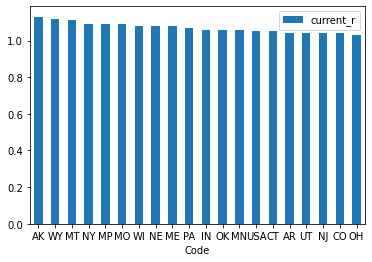

In [ ]:
df_r_values.sort_values('current_r', ascending=False).head(20).plot.bar(x='Code', y='current_r', rot=0)

##### State Meta (Name to Code pairing)

In [ ]:
df_state_meta = pd.read_csv(data_dir + 'stateMeta.csv')
df_state_meta.drop(['Abbrev'], axis=1, inplace=True)

##### Gender Ratio

In [ ]:
df_state_gender = pd.read_csv(data_dir + 'stateGenderRatio.csv')
df_state_gender = pd.merge(df_state_meta, df_state_gender)
# Numbers indicate how many men there are per 100 women in the population
df_state_gender.head()

,State,Code,SexRatio
0,Alabama,AL,93.7
1,Alaska,AK,109.3
2,Arizona,AZ,98.8
3,Arkansas,AR,96.3
4,California,CA,98.8


##### Median Age

In [ ]:
df_state_age = pd.read_csv(data_dir + 'stateMedianAge.csv')
df_state_age = pd.merge(df_state_meta, df_state_age)
df_state_age.head()

,State,Code,MedianAge,MedianAgeMale,MedianAgeFemale
0,Alabama,AL,39.0,37.5,40.5
1,Alaska,AK,34.3,33.8,34.9
2,Arizona,AZ,37.7,36.3,39.0
3,Arkansas,AR,38.1,36.8,39.5
4,California,CA,36.5,35.4,37.7


##### Population

In [ ]:
df_state_pop = pd.read_csv(data_dir + 'statePop.csv')
df_state_pop = pd.merge(df_state_meta, df_state_pop)
# Numbers indicate how many men there are per 100 women in the population
df_state_pop.head()

,State,Code,rank,Pop,Growth,Pop2018,Pop2010,growthSince2010,Percent,density
0,Alabama,AL,24,4934190,0.0095,4887680,4785440,0.0311,0.0147,97.4270
1,Alaska,AK,49,724357,-0.0147,735139,713910,0.0146,0.0022,1.2694
2,Arizona,AZ,14,7520100,0.0506,7158020,6407170,0.1737,0.0225,66.2016
3,Arkansas,AR,34,3033950,0.0080,3009730,2921960,0.0383,0.0091,58.3059
4,California,CA,1,39613500,0.0038,39461600,37319500,0.0615,0.1184,254.2929


##### Demographics

In [ ]:
df_demographics = pd.read_csv(data_dir + 'stateDemographics.csv')
df_demographics = pd.merge(df_state_meta, df_demographics)
# Numbers indicate how many men there are per 100 women in the population
df_demographics.head()

,State,Code,Age.Percent 65 and Older,Age.Percent Under 18 Years,Age.Percent Under 5 Years,Education.Bachelor's Degree or Higher,Education.High School or Higher,Employment.Nonemployer Establishments,Employment.Private Non-farm Employment,Employment.Private Non-farm Employment Percent Change,Employment.Private Non-farm Establishments,Ethnicities.American Indian and Alaska Native Alone,Ethnicities.Asian Alone,Ethnicities.Black Alone,Ethnicities.Hispanic or Latino,Ethnicities.Native Hawaiian and Other Pacific Islander Alone,Ethnicities.Two or More Races,Ethnicities.White Alone,"Ethnicities.White Alone, not Hispanic or Latino",Housing.Homeownership Rate,Housing.Households,Housing.Housing Units,Housing.Median Value of Owner-Occupied Units,Housing.Persons per Household,Housing.Units in Multi-Unit Structures,Income.Median Houseold Income,Income.Per Capita Income,Income.Persons Below Poverty Level,Miscellaneous.Building Permits,Miscellaneous.Foreign Born,Miscellaneous.Land Area,Miscellaneous.Language Other than English at Home,Miscellaneous.Living in Same House +1 Years,Miscellaneous.Manufacturers Shipments,Miscellaneous.Mean Travel Time to Work,Miscellaneous.Percent Female,Miscellaneous.Veterans,Population.2010 Population,Population.2014 Population,Population.Population Percent Change,Population.Population per Square Mile,Sales.Accommodation and Food Services Sales,Sales.Merchant Wholesaler Sales,Sales.Retail Sales,Sales.Retail Sales per Capita,Employment.Firms.American Indian-Owned,Employment.Firms.Asian-Owned,Employment.Firms.Black-Owned,Employment.Firms.Hispanic-Owned,Employment.Firms.Native Hawaiian and Other Pacific Islander-Owned,Employment.Firms.Total,Employment.Firms.Women-Owned
0,Alabama,AL,15.3,22.8,6.1,22.6,83.1,311578,1603100,1.1,97578,0.7,1.3,26.7,4.1,0.1,1.5,69.7,66.2,69.7,1838683,2207912,122500,2.55,15.9,43253,23680,18.6,13369,3.5,50645.33,5.2,85.0,1128588,24.2,51.5,388865,4779736,4849377,1.4,94.4,64263,522527,573448,12364,0.8,1.8,14.8,1.2,0.1,382350,28.1
1,Alaska,AK,9.4,25.3,7.4,27.5,91.6,52991,266627,3.3,20519,14.8,6.1,3.9,6.8,1.3,7.1,66.9,61.9,63.8,251899,308583,241800,2.75,24.0,70760,32651,9.9,1518,7.0,570640.95,16.2,80.3,82040,18.8,47.4,71004,710231,736732,3.7,1.2,18512,45636,93033,13635,10.0,3.1,1.5,0.0,0.3,68728,25.9
2,Arizona,AZ,15.9,24.1,6.4,26.9,85.7,420233,2173205,1.8,132762,5.3,3.3,4.7,30.5,0.3,2.7,83.7,56.2,64.4,2370289,2909218,165100,2.67,20.7,49774,25358,17.9,26997,13.4,113594.08,26.8,80.4,579778,24.6,50.3,522382,6392017,6731484,5.3,56.3,132685,575734,867588,13637,1.9,3.3,2.0,10.7,0.0,491529,28.1
3,Arkansas,AR,15.7,23.8,6.5,20.1,83.7,191530,978094,0.0,64772,1.0,1.5,15.6,7.0,0.3,1.9,79.7,73.4,66.7,1129723,1341033,107300,2.53,15.7,40768,22170,19.2,7666,4.5,52035.48,7.2,83.6,607355,21.3,50.9,237311,2915918,2966369,1.7,56.0,35597,296597,329742,11602,1.1,1.4,5.5,2.3,0.1,238994,24.5
4,California,CA,12.9,23.6,6.5,30.7,81.2,2983996,13401863,3.5,874243,1.7,14.4,6.5,38.6,0.5,3.7,73.2,38.5,55.3,12542460,13900766,366400,2.94,31.0,61094,29527,15.9,83645,27.0,155779.22,43.7,84.2,4913720,27.2,50.3,1893539,37253956,38802500,4.2,239.1,808527,5984564,4550322,12561,1.3,14.9,4.0,16.5,0.3,3425510,30.3


##### Merge all into one big dataset

In [ ]:
df_all = pd.merge(pd.merge(pd.merge(pd.merge(df_r_values, df_state_gender), df_state_age), df_state_pop), df_demographics)
print("Num rows: {}".format(df_all.shape[0]))
print("Num cols: {}".format(df_all.shape[1]))
df_all.head()
df_all.columns

Num rows: 50
Num cols: 71


Index(['Code', 'initial_r_0', 'inflection_date', 'post_mitigation_r',
       'reopen_date', 'reopen_r', 'cur_date', 'current_r', 'State', 'SexRatio',
       'MedianAge', 'MedianAgeMale', 'MedianAgeFemale', 'rank', 'Pop',
       'Growth', 'Pop2018', 'Pop2010', 'growthSince2010', 'Percent', 'density',
       'Age.Percent 65 and Older', 'Age.Percent Under 18 Years',
       'Age.Percent Under 5 Years', 'Education.Bachelor's Degree or Higher',
       'Education.High School or Higher',
       'Employment.Nonemployer Establishments',
       'Employment.Private Non-farm Employment',
       'Employment.Private Non-farm Employment Percent Change',
       'Employment.Private Non-farm Establishments',
       'Ethnicities.American Indian and Alaska Native Alone',
       'Ethnicities.Asian Alone', 'Ethnicities.Black Alone',
       'Ethnicities.Hispanic or Latino',
       'Ethnicities.Native Hawaiian and Other Pacific Islander Alone',
       'Ethnicities.Two or More Races', 'Ethnicities.White Alone',

#### Correlation

In [ ]:
getCorrelation(df_all, "current_r", "initial_r_0")
getCorrelation(df_all, "reopen_r", "current_r")
getCorrelation(df_all, "post_mitigation_r", "current_r")

Correlation between current_r            and                                   initial_r_0:  0.13
Correlation between reopen_r             and                                     current_r: -0.06
Correlation between post_mitigation_r    and                                     current_r: -0.19


In [ ]:
factors = ["Pop", "density", "Growth", "SexRatio", 
           "MedianAge", "MedianAgeMale", "MedianAgeFemale", "Age.Percent 65 and Older", "Age.Percent Under 18 Years", 
           "Education.Bachelor's Degree or Higher", 
           "Ethnicities.Asian Alone", "Ethnicities.Black Alone", "Ethnicities.Hispanic or Latino", "Ethnicities.White Alone", 
           "Housing.Homeownership Rate", "Housing.Persons per Household",
           "Income.Median Houseold Income", "Income.Persons Below Poverty Level",
           "Miscellaneous.Foreign Born", "Miscellaneous.Mean Travel Time to Work",
           "Employment.Firms.American Indian-Owned", "Employment.Firms.Asian-Owned", "Employment.Firms.Black-Owned", "Employment.Firms.Hispanic-Owned"]
print(factors)

['Pop', 'density', 'Growth', 'SexRatio', 'MedianAge', 'MedianAgeMale', 'MedianAgeFemale', 'Age.Percent 65 and Older', 'Age.Percent Under 18 Years', "Education.Bachelor's Degree or Higher", 'Ethnicities.Asian Alone', 'Ethnicities.Black Alone', 'Ethnicities.Hispanic or Latino', 'Ethnicities.White Alone', 'Housing.Homeownership Rate', 'Housing.Persons per Household', 'Income.Median Houseold Income', 'Income.Persons Below Poverty Level', 'Miscellaneous.Foreign Born', 'Miscellaneous.Mean Travel Time to Work', 'Employment.Firms.American Indian-Owned', 'Employment.Firms.Asian-Owned', 'Employment.Firms.Black-Owned', 'Employment.Firms.Hispanic-Owned']


In [ ]:
for factor in factors:
  getCorrelation(df_all, "current_r", factor)

Correlation between current_r            and                                           Pop: -0.18
Correlation between current_r            and                                       density: -0.04
Correlation between current_r            and                                        Growth: -0.13
Correlation between current_r            and                                      SexRatio:  0.31
Correlation between current_r            and                                     MedianAge: -0.06
Correlation between current_r            and                                 MedianAgeMale: -0.03
Correlation between current_r            and                               MedianAgeFemale: -0.08
Correlation between current_r            and                      Age.Percent 65 and Older: -0.05
Correlation between current_r            and                    Age.Percent Under 18 Years:  0.09
Correlation between current_r            and         Education.Bachelor's Degree or Higher: -0.00
Correlation between 

In [ ]:
for factor in factors:
  getCorrelation(df_all, "reopen_r", factor)

Correlation between reopen_r             and                                           Pop:  0.14
Correlation between reopen_r             and                                       density: -0.24
Correlation between reopen_r             and                                        Growth:  0.20
Correlation between reopen_r             and                                      SexRatio:  0.16
Correlation between reopen_r             and                                     MedianAge: -0.32
Correlation between reopen_r             and                                 MedianAgeMale: -0.32
Correlation between reopen_r             and                               MedianAgeFemale: -0.31
Correlation between reopen_r             and                      Age.Percent 65 and Older: -0.07
Correlation between reopen_r             and                    Age.Percent Under 18 Years:  0.28
Correlation between reopen_r             and         Education.Bachelor's Degree or Higher: -0.42
Correlation between 

In [ ]:
for factor in factors:
  getCorrelation(df_all, "post_mitigation_r", factor)

Correlation between post_mitigation_r    and                                           Pop:  0.29
Correlation between post_mitigation_r    and                                       density:  0.05
Correlation between post_mitigation_r    and                                        Growth:  0.40
Correlation between post_mitigation_r    and                                      SexRatio: -0.39
Correlation between post_mitigation_r    and                                     MedianAge: -0.15
Correlation between post_mitigation_r    and                                 MedianAgeMale: -0.17
Correlation between post_mitigation_r    and                               MedianAgeFemale: -0.13
Correlation between post_mitigation_r    and                      Age.Percent 65 and Older: -0.04
Correlation between post_mitigation_r    and                    Age.Percent Under 18 Years:  0.23
Correlation between post_mitigation_r    and         Education.Bachelor's Degree or Higher: -0.13
Correlation between 

In [ ]:
for factor in factors:
  getCorrelation(df_all, "initial_r_0", factor)

Correlation between initial_r_0          and                                           Pop:  0.27
Correlation between initial_r_0          and                                       density:  0.36
Correlation between initial_r_0          and                                        Growth: -0.22
Correlation between initial_r_0          and                                      SexRatio: -0.26
Correlation between initial_r_0          and                                     MedianAge: -0.02
Correlation between initial_r_0          and                                 MedianAgeMale: -0.04
Correlation between initial_r_0          and                               MedianAgeFemale: -0.00
Correlation between initial_r_0          and                      Age.Percent 65 and Older: -0.17
Correlation between initial_r_0          and                    Age.Percent Under 18 Years: -0.05
Correlation between initial_r_0          and         Education.Bachelor's Degree or Higher:  0.23
Correlation between 

#### Association rules

In [ ]:
factors = ["Pop", "density",  "SexRatio", 
           "MedianAge",  
           "Miscellaneous.Mean Travel Time to Work",
           "Income.Median Houseold Income",
           "Education.Bachelor's Degree or Higher", 
           "Income.Persons Below Poverty Level",
           "Ethnicities.Black Alone", 
           "Ethnicities.Hispanic or Latino", "Ethnicities.White Alone",
           "Miscellaneous.Foreign Born"]
print(len(factors))

12


##### Initial r0

In [ ]:
df = categorize_numeric_factors(df_all, factors + ["initial_r_0"])
print(df["initial_r_0"].value_counts())
df

really high initial_r_0    13
high initial_r_0           12
low initial_r_0            12
really low initial_r_0     12
Name: initial_r_0, dtype: int64


,Pop,density,SexRatio,MedianAge,Miscellaneous.Mean Travel Time to Work,Income.Median Houseold Income,Education.Bachelor's Degree or Higher,Income.Persons Below Poverty Level,Ethnicities.Black Alone,Ethnicities.Hispanic or Latino,Ethnicities.White Alone,Miscellaneous.Foreign Born,initial_r_0
0,really low Pop,NaN,really high SexRatio,really low MedianAge,really low Miscellaneous.Mean Travel Time to Work,really high Income.Median Houseold Income,high Education.Bachelor's Degree or Higher,really low Income.Persons Below Poverty Level,low Ethnicities.Black Alone,low Ethnicities.Hispanic or Latino,really low Ethnicities.White Alone,high Miscellaneous.Foreign Born,high initial_r_0
1,high Pop,low density,really low SexRatio,high MedianAge,high Miscellaneous.Mean Travel Time to Work,really low Income.Median Houseold Income,really low Education.Bachelor's Degree or Higher,really high Income.Persons Below Poverty Level,really high Ethnicities.Black Alone,really low Ethnicities.Hispanic or Latino,really low Ethnicities.White Alone,really low Miscellaneous.Foreign Born,low initial_r_0
2,low Pop,low density,low SexRatio,low MedianAge,really low Miscellaneous.Mean Travel Time to Work,really low Income.Median Houseold Income,really low Education.Bachelor's Degree or Higher,really high Income.Persons Below Poverty Level,really high Ethnicities.Black Alone,low Ethnicities.Hispanic or Latino,low Ethnicities.White Alone,low Miscellaneous.Foreign Born,really low initial_r_0
3,high Pop,low density,high SexRatio,low MedianAge,high Miscellaneous.Mean Travel Time to Work,low Income.Median Houseold Income,low Education.Bachelor's Degree or Higher,really high Income.Persons Below Poverty Level,low Ethnicities.Black Alone,really high Ethnicities.Hispanic or Latino,high Ethnicities.White Alone,really high Miscellaneous.Foreign Born,really low initial_r_0
4,really high Pop,really high density,high SexRatio,really low MedianAge,really high Miscellaneous.Mean Travel Time to ...,really high Income.Median Houseold Income,high Education.Bachelor's Degree or Higher,high Income.Persons Below Poverty Level,low Ethnicities.Black Alone,really high Ethnicities.Hispanic or Latino,low Ethnicities.White Alone,really high Miscellaneous.Foreign Born,low initial_r_0
5,high Pop,low density,really high SexRatio,really low MedianAge,high Miscellaneous.Mean Travel Time to Work,high Income.Median Houseold Income,really high Education.Bachelor's Degree or Higher,low Income.Persons Below Poverty Level,low Ethnicities.Black Alone,really high Ethnicities.Hispanic or Latino,high Ethnicities.White Alone,high Miscellaneous.Foreign Born,NaN
6,low Pop,really high density,really low SexRatio,really high MedianAge,high Miscellaneous.Mean Travel Time to Work,really high Income.Median Houseold Income,really high Education.Bachelor's Degree or Higher,really low Income.Persons Below Poverty Level,high Ethnicities.Black Alone,really high Ethnicities.Hispanic or Latino,low Ethnicities.White Alone,really high Miscellaneous.Foreign Born,really high initial_r_0
7,really low Pop,really high density,NaN,really high MedianAge,high Miscellaneous.Mean Travel Time to Work,really high Income.Median Houseold Income,high Education.Bachelor's Degree or Higher,really low Income.Persons Below Poverty Level,really high Ethnicities.Black Alone,low Ethnicities.Hispanic or Latino,really low Ethnicities.White Alone,high Miscellaneous.Foreign Born,really low initial_r_0
8,really high Pop,really high density,low SexRatio,really high MedianAge,really high Miscellaneous.Mean Travel Time to ...,low Income.Median Houseold Income,low Education.Bachelor's Degree or Higher,high Income.Persons Below Poverty Level,really high Ethnicities.Black Alone,really high Ethnicities.Hispanic or Latino,low Ethnicities.White Alone,really high Miscellaneous.Foreign Born,low initial_r_0
9,really high Pop,high density,really low SexRatio,really low MedianAge,really high Miscellaneous.Mean Travel Time to ...,low Income.Median Houseold Incom

In [ ]:
association_results = get_association_rules(df, 0.7)

Num factors: 13


In [ ]:
print_rules(association_results, "really low initial_r_0")

RelationRecord(items=frozenset({'really low density', 'high Ethnicities.White Alone', 'really low initial_r_0'}), support=0.06, ordered_statistics=[OrderedStatistic(items_base=frozenset({'really low density', 'high Ethnicities.White Alone'}), items_add=frozenset({'really low initial_r_0'}), confidence=1.0, lift=4.166666666666667), OrderedStatistic(items_base=frozenset({'high Ethnicities.White Alone', 'really low initial_r_0'}), items_add=frozenset({'really low density'}), confidence=0.75, lift=3.125)])
frozenset({'really low density', 'high Ethnicities.White Alone'}) --> frozenset({'really low initial_r_0'})
Support:     0.06
Confidence:  1.0
Lift:        4.166666666666667

RelationRecord(items=frozenset({'high Miscellaneous.Mean Travel Time to Work', 'really low initial_r_0', 'nan'}), support=0.06, ordered_statistics=[OrderedStatistic(items_base=frozenset({'high Miscellaneous.Mean Travel Time to Work', 'nan'}), items_add=frozenset({'really low initial_r_0'}), confidence=0.75, lift=3.1

In [ ]:
print_rules(association_results, "low initial_r_0")

RelationRecord(items=frozenset({'low initial_r_0', 'low Miscellaneous.Mean Travel Time to Work', 'high Ethnicities.White Alone'}), support=0.06, ordered_statistics=[OrderedStatistic(items_base=frozenset({'low Miscellaneous.Mean Travel Time to Work', 'high Ethnicities.White Alone'}), items_add=frozenset({'low initial_r_0'}), confidence=0.5, lift=2.0833333333333335), OrderedStatistic(items_base=frozenset({'low initial_r_0', 'high Ethnicities.White Alone'}), items_add=frozenset({'low Miscellaneous.Mean Travel Time to Work'}), confidence=1.0, lift=4.166666666666667), OrderedStatistic(items_base=frozenset({'low Miscellaneous.Mean Travel Time to Work', 'low initial_r_0'}), items_add=frozenset({'high Ethnicities.White Alone'}), confidence=0.6, lift=2.5)])
frozenset({'low Miscellaneous.Mean Travel Time to Work', 'high Ethnicities.White Alone'}) --> frozenset({'low initial_r_0'})
Support:     0.06
Confidence:  0.5
Lift:        2.0833333333333335

RelationRecord(items=frozenset({'low initial_r_0

In [ ]:
print_rules(association_results, "high initial_r_0")

RelationRecord(items=frozenset({'high initial_r_0', 'high Income.Median Houseold Income', 'high Ethnicities.Black Alone'}), support=0.06, ordered_statistics=[OrderedStatistic(items_base=frozenset({'high Income.Median Houseold Income', 'high Ethnicities.Black Alone'}), items_add=frozenset({'high initial_r_0'}), confidence=0.75, lift=3.125), OrderedStatistic(items_base=frozenset({'high initial_r_0', 'high Income.Median Houseold Income'}), items_add=frozenset({'high Ethnicities.Black Alone'}), confidence=0.75, lift=3.125)])
frozenset({'high Income.Median Houseold Income', 'high Ethnicities.Black Alone'}) --> frozenset({'high initial_r_0'})
Support:     0.06
Confidence:  0.75
Lift:        3.125

RelationRecord(items=frozenset({'high initial_r_0', 'high Miscellaneous.Mean Travel Time to Work', 'high Ethnicities.Black Alone'}), support=0.06, ordered_statistics=[OrderedStatistic(items_base=frozenset({'high Miscellaneous.Mean Travel Time to Work', 'high Ethnicities.Black Alone'}), items_add=fr

In [ ]:
print_rules(association_results, "really high initial_r_0")

RelationRecord(items=frozenset({'really high initial_r_0', 'high Ethnicities.Black Alone', "really high Education.Bachelor's Degree or Higher"}), support=0.08, ordered_statistics=[OrderedStatistic(items_base=frozenset({'high Ethnicities.Black Alone', "really high Education.Bachelor's Degree or Higher"}), items_add=frozenset({'really high initial_r_0'}), confidence=1.0, lift=3.846153846153846), OrderedStatistic(items_base=frozenset({'high Ethnicities.Black Alone', 'really high initial_r_0'}), items_add=frozenset({"really high Education.Bachelor's Degree or Higher"}), confidence=1.0, lift=3.846153846153846)])
frozenset({'high Ethnicities.Black Alone', "really high Education.Bachelor's Degree or Higher"}) --> frozenset({'really high initial_r_0'})
Support:     0.08
Confidence:  1.0
Lift:        3.846153846153846

RelationRecord(items=frozenset({'really high Income.Median Houseold Income', 'high Ethnicities.Black Alone', 'really high initial_r_0'}), support=0.06, ordered_statistics=[Ordere

##### Current r

In [ ]:
df = categorize_numeric_factors(df_all, factors + ["current_r"])
print(df["current_r"].value_counts())
df

really low current_r     14
really high current_r    13
low current_r            13
high current_r            9
Name: current_r, dtype: int64


,Pop,density,SexRatio,MedianAge,Miscellaneous.Mean Travel Time to Work,Income.Median Houseold Income,Education.Bachelor's Degree or Higher,Income.Persons Below Poverty Level,Ethnicities.Black Alone,Ethnicities.Hispanic or Latino,Ethnicities.White Alone,Miscellaneous.Foreign Born,current_r
0,really low Pop,NaN,really high SexRatio,really low MedianAge,really low Miscellaneous.Mean Travel Time to Work,really high Income.Median Houseold Income,high Education.Bachelor's Degree or Higher,really low Income.Persons Below Poverty Level,low Ethnicities.Black Alone,low Ethnicities.Hispanic or Latino,really low Ethnicities.White Alone,high Miscellaneous.Foreign Born,really high current_r
1,high Pop,low density,really low SexRatio,high MedianAge,high Miscellaneous.Mean Travel Time to Work,really low Income.Median Houseold Income,really low Education.Bachelor's Degree or Higher,really high Income.Persons Below Poverty Level,really high Ethnicities.Black Alone,really low Ethnicities.Hispanic or Latino,really low Ethnicities.White Alone,really low Miscellaneous.Foreign Born,really low current_r
2,low Pop,low density,low SexRatio,low MedianAge,really low Miscellaneous.Mean Travel Time to Work,really low Income.Median Houseold Income,really low Education.Bachelor's Degree or Higher,really high Income.Persons Below Poverty Level,really high Ethnicities.Black Alone,low Ethnicities.Hispanic or Latino,low Ethnicities.White Alone,low Miscellaneous.Foreign Born,high current_r
3,high Pop,low density,high SexRatio,low MedianAge,high Miscellaneous.Mean Travel Time to Work,low Income.Median Houseold Income,low Education.Bachelor's Degree or Higher,really high Income.Persons Below Poverty Level,low Ethnicities.Black Alone,really high Ethnicities.Hispanic or Latino,high Ethnicities.White Alone,really high Miscellaneous.Foreign Born,really low current_r
4,really high Pop,really high density,high SexRatio,really low MedianAge,really high Miscellaneous.Mean Travel Time to ...,really high Income.Median Houseold Income,high Education.Bachelor's Degree or Higher,high Income.Persons Below Poverty Level,low Ethnicities.Black Alone,really high Ethnicities.Hispanic or Latino,low Ethnicities.White Alone,really high Miscellaneous.Foreign Born,really low current_r
5,high Pop,low density,really high SexRatio,really low MedianAge,high Miscellaneous.Mean Travel Time to Work,high Income.Median Houseold Income,really high Education.Bachelor's Degree or Higher,low Income.Persons Below Poverty Level,low Ethnicities.Black Alone,really high Ethnicities.Hispanic or Latino,high Ethnicities.White Alone,high Miscellaneous.Foreign Born,high current_r
6,low Pop,really high density,really low SexRatio,really high MedianAge,high Miscellaneous.Mean Travel Time to Work,really high Income.Median Houseold Income,really high Education.Bachelor's Degree or Higher,really low Income.Persons Below Poverty Level,high Ethnicities.Black Alone,really high Ethnicities.Hispanic or Latino,low Ethnicities.White Alone,really high Miscellaneous.Foreign Born,really high current_r
7,really low Pop,really high density,NaN,really high MedianAge,high Miscellaneous.Mean Travel Time to Work,really high Income.Median Houseold Income,high Education.Bachelor's Degree or Higher,really low Income.Persons Below Poverty Level,really high Ethnicities.Black Alone,low Ethnicities.Hispanic or Latino,really low Ethnicities.White Alone,high Miscellaneous.Foreign Born,low current_r
8,really high Pop,really high density,low SexRatio,really high MedianAge,really high Miscellaneous.Mean Travel Time to ...,low Income.Median Houseold Income,low Education.Bachelor's Degree or Higher,high Income.Persons Below Poverty Level,really high Ethnicities.Black Alone,really high Ethnicities.Hispanic or Latino,low Ethnicities.White Alone,really high Miscellaneous.Foreign Born,low current_r
9,really high Pop,high density,really low SexRatio,really low MedianAge,really high Miscellaneous.Mean Travel Time to ...,low Income.Median Houseold Inco

In [ ]:
association_results = get_association_rules(df, 0.7)

Num factors: 13


In [ ]:
print_rules(association_results, "really low current_r")

RelationRecord(items=frozenset({"high Education.Bachelor's Degree or Higher", 'really high Miscellaneous.Mean Travel Time to Work', 'really low current_r'}), support=0.06, ordered_statistics=[OrderedStatistic(items_base=frozenset({"high Education.Bachelor's Degree or Higher", 'really high Miscellaneous.Mean Travel Time to Work'}), items_add=frozenset({'really low current_r'}), confidence=0.75, lift=2.6785714285714284), OrderedStatistic(items_base=frozenset({"high Education.Bachelor's Degree or Higher", 'really low current_r'}), items_add=frozenset({'really high Miscellaneous.Mean Travel Time to Work'}), confidence=1.0, lift=3.846153846153846), OrderedStatistic(items_base=frozenset({'really high Miscellaneous.Mean Travel Time to Work', 'really low current_r'}), items_add=frozenset({"high Education.Bachelor's Degree or Higher"}), confidence=0.75, lift=3.125)])
frozenset({"high Education.Bachelor's Degree or Higher", 'really high Miscellaneous.Mean Travel Time to Work'}) --> frozenset({'r

In [ ]:
print_rules(association_results, "low current_r")

RelationRecord(items=frozenset({'low current_r', 'low SexRatio', 'low Ethnicities.White Alone'}), support=0.06, ordered_statistics=[OrderedStatistic(items_base=frozenset({'low SexRatio', 'low Ethnicities.White Alone'}), items_add=frozenset({'low current_r'}), confidence=0.75, lift=2.8846153846153846), OrderedStatistic(items_base=frozenset({'low current_r', 'low Ethnicities.White Alone'}), items_add=frozenset({'low SexRatio'}), confidence=0.75, lift=3.125), OrderedStatistic(items_base=frozenset({'low current_r', 'low SexRatio'}), items_add=frozenset({'low Ethnicities.White Alone'}), confidence=0.75, lift=3.125)])
frozenset({'low SexRatio', 'low Ethnicities.White Alone'}) --> frozenset({'low current_r'})
Support:     0.06
Confidence:  0.75
Lift:        2.8846153846153846

RelationRecord(items=frozenset({'low MedianAge', 'low current_r', 'low Income.Persons Below Poverty Level'}), support=0.06, ordered_statistics=[OrderedStatistic(items_base=frozenset({'low MedianAge', 'low Income.Persons

In [ ]:
print_rules(association_results, "high current_r")

In [ ]:
print_rules(association_results, "really high current_r")

RelationRecord(items=frozenset({'really high current_r', "high Education.Bachelor's Degree or Higher", 'really high MedianAge'}), support=0.06, ordered_statistics=[OrderedStatistic(items_base=frozenset({"high Education.Bachelor's Degree or Higher", 'really high MedianAge'}), items_add=frozenset({'really high current_r'}), confidence=0.75, lift=2.8846153846153846), OrderedStatistic(items_base=frozenset({'really high current_r', 'really high MedianAge'}), items_add=frozenset({"high Education.Bachelor's Degree or Higher"}), confidence=0.75, lift=3.125)])
frozenset({"high Education.Bachelor's Degree or Higher", 'really high MedianAge'}) --> frozenset({'really high current_r'})
Support:     0.06
Confidence:  0.75
Lift:        2.8846153846153846

RelationRecord(items=frozenset({'high Ethnicities.White Alone', 'really high current_r', 'high Ethnicities.Black Alone'}), support=0.06, ordered_statistics=[OrderedStatistic(items_base=frozenset({'high Ethnicities.White Alone', 'high Ethnicities.Bla

### Analysis between R values and factors such as population for US counties
[Reference: Estimating and explaining the spread of COVID-19 at the county level in the USA](https://www.nature.com/articles/s42003-020-01609-6#data-availability)

In [ ]:
df_county = pd.read_csv(data_dir + "countyDataWithR0Estimates.csv")
print("Rows:", df_county.shape[0])
print("Cols:", df_county.shape[1])
df_county.head()

Rows: 160
Cols: 99


,X,state_county,fips,state,ST,start.date,end.date,duration,count.max,sr,r0,r0.Pr,r0.ave3,r0.ave5,r0.est,r0.est.se,r0.est.ave3,r0.est.ave5,r0.u95,r0.u66,r0.l66,r0.l95,r1,r1.Pr,r1.est,r1.est.se,r1.u95,r1.u66,r1.l66,r1.l95,rmax,rmax.est,rmax.u95,rmax.u66,rmax.l66,rmax.l95,rmin,rmin.est,rmin.u95,rmin.u66,...,Asian_American,Other_race,Latino_Population,Children_in_Poverty,Adults_65_Poverty.AHDP,Population.Census2019,Below_federal_poverty_threshold.AHDP,Gini_Coefficient.AHDP,Child_Poverty,Professional_occupations,Service_occupations,Sales_office_occupations,Farming_occupations,Construction_occupations,Production_occupations,county5.x,countylast,state.x,county.x,Median_Earnings.y,Gini_Coefficient.MA,Below_federal_poverty_threshold.MA,Violent_Crime.MA,At_Least_Bachelor_Degree.MA,Population.MA,White.MA,Smoker,Obesity.MA,Diabetes,Elderly_Population.MA,lat,lon,area,ST.1,pTrump,thresh,state_county.w,pop,den,region
0,3030,AL_agg,NaN,Alabama,AL,3/7/20,5/5/20,60,3.295837,0.02,0.079794,0.002361,0.078564,0.070800,0.052053,0.033887,0.051028,0.051298,0.119450,0.085633,0.017670,-0.010080,-0.011874,0.002433,-0.004616,0.033887,0.055025,0.026897,-0.039455,-0.076790,0.054219,0.052827,0.116688,0.087030,0.017544,-0.005391,NaN,-0.014905,0.052531,0.014307,...,1.050112,1.390373,4.046346,26.936709,11.178916,4489975,16.822033,0.459000,23.580623,31.111861,15.689029,25.091390,0.746751,10.798075,16.583931,"Kent County,","ent County, Delaware",DE,"Kent County, DE",NaN,0.465641,18.807402,NaN,23.802401,4416369,0.671176,19.178033,33.754167,13.535639,14.965235,33.225190,-86.618540,50778.80,2,0.629585,False,AL_agg,4489975,34.139991,South
1,642,AL_Mobile,1097.0,Alabama,AL,3/19/20,5/5/20,48,1.945910,0.02,0.037563,0.002160,0.033459,0.029541,0.025838,0.028236,0.024558,0.023571,0.079836,0.053150,-0.001783,-0.040239,-0.061242,0.002353,-0.028145,0.028236,0.041641,0.001311,-0.061542,-0.096772,0.037563,0.025838,0.079836,0.053150,-0.001783,-0.040239,-0.049874,-0.033131,0.036675,-0.004403,...,1.800000,1.400000,2.400000,34.900000,12.800000,413210,19.200000,0.470000,28.700000,29.400000,17.300000,26.900000,0.700000,11.700000,14.100000,Mobile Count,"obile County, Alabama",AL,"Mobile County, AL",27577.00000,0.469300,19.270693,549.800000,22.000000,414251,0.581363,21.642627,37.100000,15.600000,14.099181,30.683993,-88.170637,1644.14,2,0.550641,True,AL_Mobile,413210,97.036236,South
2,3022,AR_agg,NaN,Arkansas,AR,3/6/20,5/5/20,61,2.079442,0.02,0.024108,0.002074,0.023735,0.019375,0.013915,0.031022,0.012472,0.012729,0.066700,0.044940,-0.017319,-0.058019,0.024191,0.002315,0.005400,0.031022,0.062304,0.029305,-0.023365,-0.047451,0.005899,0.046901,0.097253,0.070492,0.021935,-0.004376,0.030747,-0.027378,0.026781,0.001476,...,1.243874,1.849336,6.482982,30.146782,11.214321,3017804,17.884576,0.450797,25.994789,29.796369,16.530473,24.712510,1.283943,10.223693,17.463074,Sussex Count,"ussex County, Delaware",DE,"Sussex County, DE",26493.74685,0.460943,19.322449,NaN,21.305256,2958208,0.736023,19.849237,34.425928,12.410145,15.335737,35.156505,-92.673201,53182.34,3,0.605497,True,AR_agg,3017804,21.909149,South
3,2987,AZ_agg,NaN,Arizona,AZ,3/7/20,5/5/20,60,2.995732,0.02,0.069299,0.002484,0.067888,0.064658,0.034196,0.032312,0.034129,0.033455,0.094546,0.065399,0.003171,-0.046277,0.028461,0.002351,0.037411,0.032312,0.098344,0.069940,0.003842,-0.034606,0.033951,0.055359,0.132016,0.087447,0.017982,-0.022028,0.050182,0.007377,0.067986,0.042081,...,1.089551,1.908646,26.886792,27.617358,10.386593,1746024,17.780303,0.429668,24.864301,29.279225,20.849884,25.399764,1.645571,12.058530,10.735620,Autauga Coun,"utauga County, Alabama",AL,"Autauga County, AL",24876.82310,0.440863,20.594378,285.031357,18.771061,1625248,0.561976,17.473098,28.994957,11.567971,19.098008,33.776156,-112.019184,95591.96,4,0.528744,False,AZ_agg,1746024,7.052300,West
4,4,AZ_Maricopa,4013.0,Arizona,AZ,3/7/20,5/5/20,60,3.526361,0.02,0.070658,0.002474,0.069109,0.067721,0.043217,0.030311,0.042360,0.041802,0.100553,0.073703,0.012558,-0.021878,0.023920

#### Correlation

In [ ]:
factors = ["Less_Than_High_School", "At_Least_Bachelor_Degree.AHDP", 
           "Median_Earnings.AHDP",	"Education_Index",	"Income_Index",	
           "White.AHDP",	"African_American",	"Native_American", "Asian_American",
           "Other_race",	"Latino_Population",	"Children_in_Poverty", 
           "Adults_65_Poverty.AHDP",	"Population.Census2019",	
           "Below_federal_poverty_threshold.AHDP",	"Gini_Coefficient.AHDP",
           "Child_Poverty",	"Professional_occupations",	"Service_occupations",	
           "Sales_office_occupations",	"Farming_occupations",	
           "Construction_occupations",	"Production_occupations", "Smoker",
           "Obesity.MA", "Diabetes", "pTrump", "area", "Elderly_Population.MA"]
print(factors)

['Less_Than_High_School', 'At_Least_Bachelor_Degree.AHDP', 'Median_Earnings.AHDP', 'Education_Index', 'Income_Index', 'White.AHDP', 'African_American', 'Native_American', 'Asian_American', 'Other_race', 'Latino_Population', 'Children_in_Poverty', 'Adults_65_Poverty.AHDP', 'Population.Census2019', 'Below_federal_poverty_threshold.AHDP', 'Gini_Coefficient.AHDP', 'Child_Poverty', 'Professional_occupations', 'Service_occupations', 'Sales_office_occupations', 'Farming_occupations', 'Construction_occupations', 'Production_occupations', 'Smoker', 'Obesity.MA', 'Diabetes', 'pTrump', 'area', 'Elderly_Population.MA']


In [ ]:
for factor in factors:
  getCorrelation(df_county, "r0", factor)

Correlation between r0                   and                         Less_Than_High_School:  0.14
Correlation between r0                   and                 At_Least_Bachelor_Degree.AHDP:  0.10
Correlation between r0                   and                          Median_Earnings.AHDP:  0.17
Correlation between r0                   and                               Education_Index:  0.11
Correlation between r0                   and                                  Income_Index:  0.16
Correlation between r0                   and                                    White.AHDP: -0.16
Correlation between r0                   and                              African_American:  0.08
Correlation between r0                   and                               Native_American: -0.13
Correlation between r0                   and                                Asian_American:  0.17
Correlation between r0                   and                                    Other_race:  0.02
Correlation between 

#### Association rules

In [ ]:
factors = ["Less_Than_High_School",
           "Median_Earnings.AHDP",
           "White.AHDP",	
           "African_American",	
           "Native_American", 
           "Asian_American",
           "Latino_Population",	
           "Adults_65_Poverty.AHDP",	
           "Population.Census2019",	
           "Gini_Coefficient.AHDP",
           "Professional_occupations",	
           "Service_occupations",	
           "Sales_office_occupations",	
           "Construction_occupations",
           "Smoker",
           "Obesity.MA"]
print(len(factors))

16


In [ ]:
df = categorize_numeric_factors(df_county, factors + ["r0"])
print(df["r0"].value_counts())
df

really high r0    40
high r0           40
low r0            40
really low r0     39
Name: r0, dtype: int64


,Less_Than_High_School,Median_Earnings.AHDP,White.AHDP,African_American,Native_American,Asian_American,Latino_Population,Adults_65_Poverty.AHDP,Population.Census2019,Gini_Coefficient.AHDP,Professional_occupations,Service_occupations,Sales_office_occupations,Construction_occupations,Smoker,Obesity.MA,r0
0,really high Less_Than_High_School,really low Median_Earnings.AHDP,high White.AHDP,really high African_American,really high Native_American,really low Asian_American,really low Latino_Population,really high Adults_65_Poverty.AHDP,really high Population.Census2019,high Gini_Coefficient.AHDP,really low Professional_occupations,low Service_occupations,low Sales_office_occupations,really high Construction_occupations,really high Smoker,really high Obesity.MA,low r0
1,really high Less_Than_High_School,really low Median_Earnings.AHDP,low White.AHDP,really high African_American,really high Native_American,low Asian_American,really low Latino_Population,really high Adults_65_Poverty.AHDP,really low Population.Census2019,really high Gini_Coefficient.AHDP,really low Professional_occupations,high Service_occupations,really high Sales_office_occupations,really high Construction_occupations,really high Smoker,really high Obesity.MA,really low r0
2,really high Less_Than_High_School,really low Median_Earnings.AHDP,high White.AHDP,high African_American,really high Native_American,really low Asian_American,low Latino_Population,really high Adults_65_Poverty.AHDP,really high Population.Census2019,high Gini_Coefficient.AHDP,really low Professional_occupations,low Service_occupations,low Sales_office_occupations,really high Construction_occupations,really high Smoker,really high Obesity.MA,really low r0
3,really high Less_Than_High_School,really low Median_Earnings.AHDP,low White.AHDP,really low African_American,really high Native_American,really low Asian_American,really high Latino_Population,really high Adults_65_Poverty.AHDP,high Population.Census2019,low Gini_Coefficient.AHDP,really low Professional_occupations,really high Service_occupations,low Sales_office_occupations,really high Construction_occupations,high Smoker,high Obesity.MA,low r0
4,high Less_Than_High_School,high Median_Earnings.AHDP,low White.AHDP,low African_American,really high Native_American,high Asian_American,really high Latino_Population,low Adults_65_Poverty.AHDP,really high Population.Census2019,low Gini_Coefficient.AHDP,low Professional_occupations,high Service_occupations,really high Sales_office_occupations,high Construction_occupations,really low Smoker,low Obesity.MA,low r0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,low Less_Than_High_School,low Median_Earnings.AHDP,high White.AHDP,really low African_American,really high Native_American,high Asian_American,high Latino_Population,low Adults_65_Poverty.AHDP,really high Population.Census2019,really low Gini_Coefficient.AHDP,low Professional_occupations,high Service_occupations,really low Sales_office_occupations,high Construction_occupations,low Smoker,high Obesity.MA,high r0
156,really low Less_Than_High_School,really high Median_Earnings.AHDP,low White.AHDP,low African_American,really high Native_American,really high Asian_American,low Latino_Population,high Adults_65_Poverty.AHDP,really high Population.Census2019,high Gini_Coefficient.AHDP,really high Professional_occupations,really low Service_occupations,really low Sales_office_occupations,really low Construction_occupations,really low Smoker,really low Obesity.MA,low r0
157,really low Less_Than_High_School,really high Median_Earnings.AHDP,high White.AHDP,really low African_American,really high Native_American,really high Asian_American,high Latino_Population,low Adults_65_Poverty.AHDP,low Population.Census2019,really low Gini_Coefficient.AHDP,low Professional_occupations,low Service_occupations,low Sales_office_occupations,really high Construction_occupations,really low Smoker,high Obesity.MA,really low r0
158,really low Less_Than

In [ ]:
association_results = get_association_rules(df, 0.6)

Num factors: 17


In [ ]:
print_rules(association_results, "really low r0")

RelationRecord(items=frozenset({'high African_American', 'really low r0', 'low Gini_Coefficient.AHDP'}), support=0.05, ordered_statistics=[OrderedStatistic(items_base=frozenset({'high African_American', 'low Gini_Coefficient.AHDP'}), items_add=frozenset({'really low r0'}), confidence=0.6153846153846154, lift=2.52465483234714), OrderedStatistic(items_base=frozenset({'high African_American', 'really low r0'}), items_add=frozenset({'low Gini_Coefficient.AHDP'}), confidence=0.6666666666666667, lift=2.0915032679738568)])
frozenset({'high African_American', 'low Gini_Coefficient.AHDP'}) --> frozenset({'really low r0'})
Support:     0.05
Confidence:  0.6153846153846154
Lift:        2.52465483234714

RelationRecord(items=frozenset({'high African_American', 'really low Population.Census2019', 'really low r0'}), support=0.05, ordered_statistics=[OrderedStatistic(items_base=frozenset({'high African_American', 'really low Population.Census2019'}), items_add=frozenset({'really low r0'}), confidence

In [ ]:
print_rules(association_results, "low r0")

In [ ]:
print_rules(association_results, "high r0")

In [ ]:
print_rules(association_results, "really high r0")

RelationRecord(items=frozenset({'high African_American', 'really high r0', 'high Population.Census2019'}), support=0.05, ordered_statistics=[OrderedStatistic(items_base=frozenset({'high African_American', 'high Population.Census2019'}), items_add=frozenset({'really high r0'}), confidence=0.6153846153846154, lift=2.4615384615384617)])
frozenset({'high African_American', 'high Population.Census2019'}) --> frozenset({'really high r0'})
Support:     0.05
Confidence:  0.6153846153846154
Lift:        2.4615384615384617

RelationRecord(items=frozenset({'high African_American', 'low White.AHDP', 'really high r0'}), support=0.05, ordered_statistics=[OrderedStatistic(items_base=frozenset({'high African_American', 'low White.AHDP'}), items_add=frozenset({'really high r0'}), confidence=0.6153846153846154, lift=2.4615384615384617), OrderedStatistic(items_base=frozenset({'low White.AHDP', 'really high r0'}), items_add=frozenset({'high African_American'}), confidence=0.6666666666666667, lift=2.666666

### Analysis between deaths and factors such as population for ALL US counties

#### Data Collection and cleaning

In [4]:
df_counties_covid = pd.read_csv(data_dir + "/county/us-counties-recent.csv")
df_counties_education = pd.read_csv(data_dir + "/county/Education.csv", thousands=',')
df_counties_pop = pd.read_csv(data_dir + "/county/PopulationEstimates.csv", thousands=',')
df_counties_poverty = pd.read_csv(data_dir + "/county/PovertyEstimates.csv", thousands=',')
df_counties_emplyoment = pd.read_csv(data_dir + "/county/Unemployment.csv", thousands=',')
df_counties_medicare = pd.read_csv(data_dir + "/county/medicare_data.csv", thousands=',')
df_counties_mask = pd.read_csv(data_dir + "/county/mask-use-by-county.csv", thousands=',')
df_counties_race = pd.read_csv(data_dir + "/county/race_data.csv", thousands=',')
df_counties_race = df_counties_race[df_counties_race["year"] == 2019]
df_counties_race.head()

,fips,STFIPS,COFIPS,state_abbrev,state,county,year,pop,white_pop,black_pop,asian_pop,indian_pop,pacific_pop,two_pop,not_hisp_pop,hisp_pop
9,1001,1,1,AL,Alabama,Autauga,2019,55869,42607,11237,656,266,58,1045,54198,1671
19,1003,1,3,AL,Alabama,Baldwin,2019,223234,195198,19593,2380,1742,154,4167,212700,10534
29,1005,1,5,AL,Alabama,Barbour,2019,24686,12134,11906,116,170,52,308,23569,1117
39,1007,1,7,AL,Alabama,Bibb,2019,22394,17191,4763,48,103,26,263,21771,623
49,1009,1,9,AL,Alabama,Blount,2019,57826,55412,978,185,370,67,814,52244,5582


In [74]:
df_counties_covid = df_counties_covid[df_counties_covid["date"] == '3/2/21']
df_all = df_counties_covid
for df in [df_counties_education, df_counties_pop, df_counties_poverty, 
           df_counties_emplyoment, df_counties_medicare, df_counties_race,
           df_counties_mask]:
  df_all = pd.merge(df_all, df, on="fips")
print("Num rows: {}".format(df_all.shape[0]))
print("Num cols: {}".format(df_all.shape[1]))
print('\n'.join(list(df_all.columns)))
df_all.head()

Num rows: 3129
Num cols: 372
date
county_x
state_x
fips
cases
deaths
State_x
Area name
2003 Rural-urban Continuum Code
2003 Urban Influence Code
2013 Rural-urban Continuum Code
2013 Urban Influence Code
Less than a high school diploma, 1970
High school diploma only, 1970
Some college (1-3 years), 1970
Four years of college or higher, 1970
Percent of adults with less than a high school diploma, 1970
Percent of adults with a high school diploma only, 1970
Percent of adults completing some college (1-3 years), 1970
Percent of adults completing four years of college or higher, 1970
Less than a high school diploma, 1980
High school diploma only, 1980
Some college (1-3 years), 1980
Four years of college or higher, 1980
Percent of adults with less than a high school diploma, 1980
Percent of adults with a high school diploma only, 1980
Percent of adults completing some college (1-3 years), 1980
Percent of adults completing four years of college or higher, 1980
Less than a high school diploma, 

,date,county_x,state_x,fips,cases,deaths,State_x,Area name,2003 Rural-urban Continuum Code,2003 Urban Influence Code,2013 Rural-urban Continuum Code,2013 Urban Influence Code,"Less than a high school diploma, 1970","High school diploma only, 1970","Some college (1-3 years), 1970","Four years of college or higher, 1970","Percent of adults with less than a high school diploma, 1970","Percent of adults with a high school diploma only, 1970","Percent of adults completing some college (1-3 years), 1970","Percent of adults completing four years of college or higher, 1970","Less than a high school diploma, 1980","High school diploma only, 1980","Some college (1-3 years), 1980","Four years of college or higher, 1980","Percent of adults with less than a high school diploma, 1980","Percent of adults with a high school diploma only, 1980","Percent of adults completing some college (1-3 years), 1980","Percent of adults completing four years of college or higher, 1980","Less than a high school diploma, 1990","High school diploma only, 1990","Some college or associate's degree, 1990","Bachelor's degree or higher, 1990","Percent of adults with less than a high school diploma, 1990","Percent of adults with a high school diploma only, 1990","Percent of adults completing some college or associate's degree, 1990","Percent of adults with a bachelor's degree or higher, 1990","Less than a high school diploma, 2000","High school diploma only, 2000","Some college or associate's degree, 2000","Bachelor's degree or higher, 2000",...,Unemployed_2019,Unemployment_rate_2019,Median_Household_Income_2019,Med_HH_Income_Percent_of_State_Total_2019,County name,Medicare enrollees (2014),Total Medicare reimbursements per enrollee (Parts A and B) (2014),Unnamed: 4,Hospital & skilled nursing facility reimbursements per enrollee (2014),Unnamed: 6,Physician reimbursements per enrollee (2014),Unnamed: 8,Outpatient facility reimbursements per enrollee (2014),Unnamed: 10,Home health agency reimbursements per enrollee (2014),Unnamed: 12,Hospice reimbursements per enrollee (2014),Unnamed: 14,Durable medical equipment reimbursements per enrollee (2014),Unnamed: 16,STFIPS,COFIPS,state_abbrev,state_y,county_y,year,pop,white_pop,black_pop,asian_pop,indian_pop,pacific_pop,two_pop,not_hisp_pop,hisp_pop,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
0,3/2/21,Autauga,Alabama,1001.0,6303,91.0,AL,Autauga County,2.0,2.0,2.0,2.0,6611.0,3757.0,933.0,767.0,54.8,31.1,7.7,6.4,7074.0,6145.0,2104.0,2117.0,40.6,35.2,12.1,12.1,6252.0,6671.0,4912.0,3026.0,30.0,32.0,23.5,14.5,5872.0,9332.0,7413.0,4972.0,...,714.0,2.7,58233.0,112.5,AL-Autauga County,4649.0,"8,499","9,859","3,224","4,053","2,371","2,539","1,712","1,949",420,477,521,628,252,233,1,1,AL,Alabama,Autauga,2019,55869,42607,11237,656,266,58,1045,54198,1671,0.053,0.074,0.134,0.295,0.444
1,3/2/21,Baldwin,Alabama,1003.0,19790,284.0,AL,Baldwin County,4.0,5.0,3.0,2.0,18726.0,8426.0,2334.0,2038.0,59.4,26.7,7.4,6.5,18125.0,15380.0,6602.0,5498.0,39.7,33.7,14.5,12.1,17309.0,20544.0,15900.0,10870.0,26.8,31.8,24.6,16.8,17258.0,28428.0,28178.0,22146.0,...,2653.0,2.7,59871.0,115.6,AL-Baldwin County,22607.0,"8,029","9,413","2,809","3,696","2,690","2,847","1,310","1,519",576,682,385,451,248,227,1,3,AL,Alabama,Baldwin,2019,223234,195198,19593,2380,1742,154,4167,212700,10534,0.083,0.059,0.098,0.323,0.436
2,3/2/21,Barbour,Alabama,1005.0,2124,51.0,AL,Barbour County,6.0,6.0,6.0,6.0,8120.0,2242.0,581.0,861.0,68.8,19.0,4.9,7.3,7759.0,3671.0,1362.0,1300.0,55.1,26.1,9.7,9.2,6965.0,4258.0,2622.0,1857.0,44.4,27.1,16.7,11.8,6679.0,6124.0,4025.0,2068.0,...,324.0,3.8,35972.0,69.5,AL-Barbour County,3037.0,"8,708","10,117","3,368","4,168","2,442","2,610","1,523","1,770",539,628,613,731,256,235,1,5,AL,Alabama,Barbour,2019,24686,12134,11906,116,170,52,308,23569,1117,0.067,0.121,0.120,0.201,0.491
3,3/2/21,Bibb,Alabama,1007.0,2454,60.0,AL,Bibb County,1.0,1.0,1.0,1.0,5272.0,1402.0,238.0,302.0,73.1,19.4,3.3,4.2,5254.0,2611.0,536.0,433.0,59.5,29.6,6.1,4.9,4850.0,3407.0,1332.0,47

#### Correlation

In [31]:
factors = ["Median_Household_Income_2019", 
           "Unemployment_rate_2019", "Bachelor's degree or higher, 2000", 
           "INTERNATIONAL_MIG_2019",
           "DOMESTIC_MIG_2019", "GQ_ESTIMATES_2019", "R_death_2019", 
           "POP_ESTIMATE_2019", 
           "Percent of adults with a high school diploma only, 2015-19", 
           "N_POP_CHG_2019", "POVALL_2019", "Civilian_labor_force_2019",
           "Med_HH_Income_Percent_of_State_Total_2019", 
           "hisp_pop", "black_pop", "white_pop", "Medicare enrollees (2014)",
           "2013 Urban Influence Code",
           "NEVER", "RARELY", "SOMETIMES", "FREQUENTLY", "ALWAYS"]
df_all[factors].head()

,Median_Household_Income_2019,Unemployment_rate_2019,"Bachelor's degree or higher, 2000",INTERNATIONAL_MIG_2019,DOMESTIC_MIG_2019,GQ_ESTIMATES_2019,R_death_2019,POP_ESTIMATE_2019,"Percent of adults with a high school diploma only, 2015-19",N_POP_CHG_2019,POVALL_2019,Civilian_labor_force_2019,Med_HH_Income_Percent_of_State_Total_2019,hisp_pop,black_pop,white_pop,Medicare enrollees (2014),2013 Urban Influence Code,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
0,58233.0,2.7,4972.0,-16.0,270.0,455.0,9.7,55869,33.6,336.0,6723,26172.0,112.5,1671,11237,42607,4649.0,2.0,0.053,0.074,0.134,0.295,0.444
1,59871.0,2.7,22146.0,80.0,5297.0,2170.0,10.5,223234,27.7,5379.0,22360,97328.0,115.6,10534,19593,195198,22607.0,2.0,0.083,0.059,0.098,0.323,0.436
2,35972.0,3.8,2068.0,13.0,-141.0,2812.0,12.6,24686,35.6,-186.0,5909,8537.0,69.5,1117,11906,12134,3037.0,6.0,0.067,0.121,0.120,0.201,0.491
3,47918.0,3.1,962.0,10.0,31.0,2148.0,11.3,22394,44.9,27.0,4101,8685.0,92.6,623,4763,17191,1839.0,1.0,0.020,0.034,0.096,0.278,0.572
4,52902.0,2.7,3235.0,6.0,59.0,489.0,11.4,57826,33.4,55.0,9324,25331.0,102.2,5582,978,55412,4408.0,1.0,0.053,0.114,0.180,0.194,0.459


In [32]:
# Normalize data to be independent of population size
for factor in ["Median_Household_Income_2019",
               "deaths", "cases", "Bachelor's degree or higher, 2000", "R_death_2019", 
               "POVALL_2019", "Civilian_labor_force_2019", 
               "hisp_pop", "black_pop", "white_pop", "Medicare enrollees (2014)"]:
  df_all[factor] = df_all[factor] / df_all["POP_ESTIMATE_2019"]
df_all[factors].head()

,Median_Household_Income_2019,Unemployment_rate_2019,"Bachelor's degree or higher, 2000",INTERNATIONAL_MIG_2019,DOMESTIC_MIG_2019,GQ_ESTIMATES_2019,R_death_2019,POP_ESTIMATE_2019,"Percent of adults with a high school diploma only, 2015-19",N_POP_CHG_2019,POVALL_2019,Civilian_labor_force_2019,Med_HH_Income_Percent_of_State_Total_2019,hisp_pop,black_pop,white_pop,Medicare enrollees (2014),2013 Urban Influence Code,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
0,1.042313,2.7,0.088994,-16.0,270.0,455.0,0.000174,55869,33.6,336.0,0.120335,0.468453,112.5,0.029909,0.201131,0.762623,0.083213,2.0,0.053,0.074,0.134,0.295,0.444
1,0.268198,2.7,0.099205,80.0,5297.0,2170.0,0.000047,223234,27.7,5379.0,0.100164,0.435991,115.6,0.047188,0.087769,0.874410,0.101270,2.0,0.083,0.059,0.098,0.323,0.436
2,1.457182,3.8,0.083772,13.0,-141.0,2812.0,0.000510,24686,35.6,-186.0,0.239366,0.345824,69.5,0.045248,0.482298,0.491534,0.123025,6.0,0.067,0.121,0.120,0.201,0.491
3,2.139770,3.1,0.042958,10.0,31.0,2148.0,0.000505,22394,44.9,27.0,0.183129,0.387827,92.6,0.027820,0.212691,0.767661,0.082120,1.0,0.020,0.034,0.096,0.278,0.572
4,0.914848,2.7,0.055944,6.0,59.0,489.0,0.000197,57826,33.4,55.0,0.161242,0.438056,102.2,0.096531,0.016913,0.958254,0.076229,1.0,0.053,0.114,0.180,0.194,0.459


In [23]:
for factor in factors:
  getCorrelation(df_all, "deaths", factor)

Correlation between deaths               and                  Median_Household_Income_2019:  0.13
Correlation between deaths               and                        Unemployment_rate_2019: -0.06
Correlation between deaths               and             Bachelor's degree or higher, 2000:  0.56
Correlation between deaths               and                        INTERNATIONAL_MIG_2019: -0.05
Correlation between deaths               and                             DOMESTIC_MIG_2019: -0.01
Correlation between deaths               and                             GQ_ESTIMATES_2019: -0.11
Correlation between deaths               and                                  R_death_2019:  0.47
Correlation between deaths               and                             POP_ESTIMATE_2019: -0.09
Correlation between deaths               and Percent of adults with a high school diploma only, 2015-19:  0.03
Correlation between deaths               and                                N_POP_CHG_2019: -0.06
Correla

In [24]:
for factor in factors:
  getCorrelation(df_all, "cases", factor)

Correlation between cases                and                  Median_Household_Income_2019:  0.23
Correlation between cases                and                        Unemployment_rate_2019: -0.11
Correlation between cases                and             Bachelor's degree or higher, 2000:  0.79
Correlation between cases                and                        INTERNATIONAL_MIG_2019: -0.08
Correlation between cases                and                             DOMESTIC_MIG_2019: -0.01
Correlation between cases                and                             GQ_ESTIMATES_2019: -0.18
Correlation between cases                and                                  R_death_2019:  0.55
Correlation between cases                and                             POP_ESTIMATE_2019: -0.15
Correlation between cases                and Percent of adults with a high school diploma only, 2015-19:  0.05
Correlation between cases                and                                N_POP_CHG_2019: -0.10
Correla

#### Association rules

##### Deaths

In [ ]:
# Limit to fewer factors for better results
factors = ["Median_Household_Income_2019", 
           "Unemployment_rate_2019", 
           "Bachelor's degree or higher, 2000", 
           "INTERNATIONAL_MIG_2019",
           "DOMESTIC_MIG_2019", 
           "GQ_ESTIMATES_2019", 
           "R_death_2019", 
           "POVALL_2019",
           "Med_HH_Income_Percent_of_State_Total_2019", 
           "hisp_pop", "black_pop", "white_pop", "Medicare enrollees (2014)"]

In [ ]:
df = categorize_numeric_factors(df_all, factors + ["deaths"])
print(df["deaths"].value_counts())
df.head()

really high deaths    782
high deaths           782
low deaths            782
really low deaths     721
Name: deaths, dtype: int64


,Median_Household_Income_2019,Unemployment_rate_2019,"Bachelor's degree or higher, 2000",INTERNATIONAL_MIG_2019,DOMESTIC_MIG_2019,GQ_ESTIMATES_2019,R_death_2019,POVALL_2019,Med_HH_Income_Percent_of_State_Total_2019,hisp_pop,black_pop,white_pop,Medicare enrollees (2014),deaths
0,low Median_Household_Income_2019,really low Unemployment_rate_2019,"low Bachelor's degree or higher, 2000",really low INTERNATIONAL_MIG_2019,really high DOMESTIC_MIG_2019,low GQ_ESTIMATES_2019,low R_death_2019,low POVALL_2019,really high Med_HH_Income_Percent_of_State_Tot...,low hisp_pop,really high black_pop,really low white_pop,really low Medicare enrollees (2014),high deaths
1,really low Median_Household_Income_2019,really low Unemployment_rate_2019,"high Bachelor's degree or higher, 2000",really high INTERNATIONAL_MIG_2019,really high DOMESTIC_MIG_2019,high GQ_ESTIMATES_2019,really low R_death_2019,really low POVALL_2019,really high Med_HH_Income_Percent_of_State_Tot...,high hisp_pop,high black_pop,low white_pop,low Medicare enrollees (2014),low deaths
2,low Median_Household_Income_2019,high Unemployment_rate_2019,"low Bachelor's degree or higher, 2000",high INTERNATIONAL_MIG_2019,really low DOMESTIC_MIG_2019,really high GQ_ESTIMATES_2019,high R_death_2019,really high POVALL_2019,really low Med_HH_Income_Percent_of_State_Tota...,high hisp_pop,really high black_pop,really low white_pop,high Medicare enrollees (2014),high deaths
3,high Median_Household_Income_2019,low Unemployment_rate_2019,"really low Bachelor's degree or higher, 2000",high INTERNATIONAL_MIG_2019,high DOMESTIC_MIG_2019,high GQ_ESTIMATES_2019,high R_death_2019,really high POVALL_2019,high Med_HH_Income_Percent_of_State_Total_2019,low hisp_pop,really high black_pop,really low white_pop,really low Medicare enrollees (2014),really high deaths
4,low Median_Household_Income_2019,really low Unemployment_rate_2019,"really low Bachelor's degree or higher, 2000",high INTERNATIONAL_MIG_2019,high DOMESTIC_MIG_2019,low GQ_ESTIMATES_2019,low R_death_2019,high POVALL_2019,really high Med_HH_Income_Percent_of_State_Tot...,high hisp_pop,low black_pop,really high white_pop,really low Medicare enrollees (2014),high deaths


In [ ]:
association_results = get_association_rules(df, 0.4)

Num factors: 14


In [ ]:
print_rules(association_results, "really low deaths")

RelationRecord(items=frozenset({'really low deaths', 'really high Median_Household_Income_2019', 'really high DOMESTIC_MIG_2019'}), support=0.05113454777884308, ordered_statistics=[OrderedStatistic(items_base=frozenset({'really high Median_Household_Income_2019', 'really high DOMESTIC_MIG_2019'}), items_add=frozenset({'really low deaths'}), confidence=0.44568245125348194, lift=1.9341752981583147), OrderedStatistic(items_base=frozenset({'really low deaths', 'really high DOMESTIC_MIG_2019'}), items_add=frozenset({'really high Median_Household_Income_2019'}), confidence=0.627450980392157, lift=2.5106062885512266), OrderedStatistic(items_base=frozenset({'really low deaths', 'really high Median_Household_Income_2019'}), items_add=frozenset({'really high DOMESTIC_MIG_2019'}), confidence=0.5498281786941581, lift=2.2056568860692574)])
frozenset({'really high Median_Household_Income_2019', 'really high DOMESTIC_MIG_2019'}) --> frozenset({'really low deaths'})
Support:     0.05113454777884308
Co

In [ ]:
print_rules(association_results, "low deaths")

In [ ]:
print_rules(association_results, "high deaths")

In [ ]:
print_rules(association_results, "really high deaths")

RelationRecord(items=frozenset({'really high POVALL_2019', 'really high deaths'}), support=0.10642377756471716, ordered_statistics=[OrderedStatistic(items_base=frozenset({'really high POVALL_2019'}), items_add=frozenset({'really high deaths'}), confidence=0.4258312020460358, lift=1.7038693493632302), OrderedStatistic(items_base=frozenset({'really high deaths'}), items_add=frozenset({'really high POVALL_2019'}), confidence=0.4258312020460358, lift=1.7038693493632302)])
frozenset({'really high POVALL_2019'}) --> frozenset({'really high deaths'})
Support:     0.10642377756471716
Confidence:  0.4258312020460358
Lift:        1.7038693493632302

RelationRecord(items=frozenset({'really high POVALL_2019', 'really high Unemployment_rate_2019', 'really high deaths'}), support=0.05496963886225631, ordered_statistics=[OrderedStatistic(items_base=frozenset({'really high POVALL_2019', 'really high Unemployment_rate_2019'}), items_add=frozenset({'really high deaths'}), confidence=0.4310776942355889, 

##### Cases

In [ ]:
# Limit to fewer factors for better results
factors = ["Unemployment_rate_2019", 
           "Bachelor's degree or higher, 2000", 
           "GQ_ESTIMATES_2019", 
           "POVALL_2019",
           "Med_HH_Income_Percent_of_State_Total_2019", 
           "hisp_pop", "black_pop", "white_pop",
           "NEVER", "RARELY", "SOMETIMES", "FREQUENTLY", "ALWAYS"]

In [ ]:
df = categorize_numeric_factors(df_all, factors + ["cases"])
print(df["cases"].value_counts())
df.head()

really high cases    782
high cases           782
low cases            782
really low cases     782
Name: cases, dtype: int64


,Unemployment_rate_2019,"Bachelor's degree or higher, 2000",GQ_ESTIMATES_2019,POVALL_2019,Med_HH_Income_Percent_of_State_Total_2019,hisp_pop,black_pop,white_pop,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,cases
0,really low Unemployment_rate_2019,"low Bachelor's degree or higher, 2000",low GQ_ESTIMATES_2019,low POVALL_2019,really high Med_HH_Income_Percent_of_State_Tot...,low hisp_pop,really high black_pop,really low white_pop,low NEVER,high RARELY,high SOMETIMES,really high FREQUENTLY,low ALWAYS,really high cases
1,really low Unemployment_rate_2019,"high Bachelor's degree or higher, 2000",high GQ_ESTIMATES_2019,really low POVALL_2019,really high Med_HH_Income_Percent_of_State_Tot...,high hisp_pop,high black_pop,low white_pop,high NEVER,low RARELY,low SOMETIMES,really high FREQUENTLY,low ALWAYS,low cases
2,high Unemployment_rate_2019,"low Bachelor's degree or higher, 2000",really high GQ_ESTIMATES_2019,really high POVALL_2019,really low Med_HH_Income_Percent_of_State_Tota...,high hisp_pop,really high black_pop,really low white_pop,low NEVER,really high RARELY,high SOMETIMES,low FREQUENTLY,low ALWAYS,low cases
3,low Unemployment_rate_2019,"really low Bachelor's degree or higher, 2000",high GQ_ESTIMATES_2019,really high POVALL_2019,high Med_HH_Income_Percent_of_State_Total_2019,low hisp_pop,really high black_pop,really low white_pop,really low NEVER,really low RARELY,low SOMETIMES,really high FREQUENTLY,high ALWAYS,really high cases
4,really low Unemployment_rate_2019,"really low Bachelor's degree or higher, 2000",low GQ_ESTIMATES_2019,high POVALL_2019,really high Med_HH_Income_Percent_of_State_Tot...,high hisp_pop,low black_pop,really high white_pop,low NEVER,high RARELY,really high SOMETIMES,low FREQUENTLY,low ALWAYS,high cases


In [ ]:
association_results = get_association_rules(df, 0.4)

Num factors: 14


In [ ]:
print_rules(association_results, "really low cases")

RelationRecord(items=frozenset({'really low cases', 'really high ALWAYS'}), support=0.11377436880792585, ordered_statistics=[OrderedStatistic(items_base=frozenset({'really high ALWAYS'}), items_add=frozenset({'really low cases'}), confidence=0.4569961489088575, lift=1.828568989687743), OrderedStatistic(items_base=frozenset({'really low cases'}), items_add=frozenset({'really high ALWAYS'}), confidence=0.45524296675191817, lift=1.828568989687743)])
frozenset({'really high ALWAYS'}) --> frozenset({'really low cases'})
Support:     0.11377436880792585
Confidence:  0.4569961489088575
Lift:        1.828568989687743

RelationRecord(items=frozenset({'really low cases', 'really low NEVER'}), support=0.10418664109939278, ordered_statistics=[OrderedStatistic(items_base=frozenset({'really low NEVER'}), items_add=frozenset({'really low cases'}), confidence=0.40852130325814534, lift=1.6346076187912235), OrderedStatistic(items_base=frozenset({'really low cases'}), items_add=frozenset({'really low NEV

In [ ]:
print_rules(association_results, "low cases")

In [ ]:
print_rules(association_results, "high cases")

In [ ]:
print_rules(association_results, "really high cases")

#### Hypothesis Testing
Reference: https://github.com/tirthajyoti/Stats-Maths-with-Python/blob/master/Intro_Hypothesis_Testing.ipynb

In [25]:
df_all.head(5)

,date,county_x,state_x,fips,cases,deaths,State_x,Area name,2003 Rural-urban Continuum Code,2003 Urban Influence Code,2013 Rural-urban Continuum Code,2013 Urban Influence Code,"Less than a high school diploma, 1970","High school diploma only, 1970","Some college (1-3 years), 1970","Four years of college or higher, 1970","Percent of adults with less than a high school diploma, 1970","Percent of adults with a high school diploma only, 1970","Percent of adults completing some college (1-3 years), 1970","Percent of adults completing four years of college or higher, 1970","Less than a high school diploma, 1980","High school diploma only, 1980","Some college (1-3 years), 1980","Four years of college or higher, 1980","Percent of adults with less than a high school diploma, 1980","Percent of adults with a high school diploma only, 1980","Percent of adults completing some college (1-3 years), 1980","Percent of adults completing four years of college or higher, 1980","Less than a high school diploma, 1990","High school diploma only, 1990","Some college or associate's degree, 1990","Bachelor's degree or higher, 1990","Percent of adults with less than a high school diploma, 1990","Percent of adults with a high school diploma only, 1990","Percent of adults completing some college or associate's degree, 1990","Percent of adults with a bachelor's degree or higher, 1990","Less than a high school diploma, 2000","High school diploma only, 2000","Some college or associate's degree, 2000","Bachelor's degree or higher, 2000",...,Unemployed_2019,Unemployment_rate_2019,Median_Household_Income_2019,Med_HH_Income_Percent_of_State_Total_2019,County name,Medicare enrollees (2014),Total Medicare reimbursements per enrollee (Parts A and B) (2014),Unnamed: 4,Hospital & skilled nursing facility reimbursements per enrollee (2014),Unnamed: 6,Physician reimbursements per enrollee (2014),Unnamed: 8,Outpatient facility reimbursements per enrollee (2014),Unnamed: 10,Home health agency reimbursements per enrollee (2014),Unnamed: 12,Hospice reimbursements per enrollee (2014),Unnamed: 14,Durable medical equipment reimbursements per enrollee (2014),Unnamed: 16,STFIPS,COFIPS,state_abbrev,state_y,county_y,year,pop,white_pop,black_pop,asian_pop,indian_pop,pacific_pop,two_pop,not_hisp_pop,hisp_pop,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
0,3/2/21,Autauga,Alabama,1001.0,0.201932,0.002915,AL,Autauga County,2.0,2.0,2.0,2.0,6611.0,3757.0,933.0,767.0,54.8,31.1,7.7,6.4,7074.0,6145.0,2104.0,2117.0,40.6,35.2,12.1,12.1,6252.0,6671.0,4912.0,3026.0,30.0,32.0,23.5,14.5,5872.0,9332.0,7413.0,0.159290,...,714.0,2.7,1.865638,112.5,AL-Autauga County,0.148942,"8,499","9,859","3,224","4,053","2,371","2,539","1,712","1,949",420,477,521,628,252,233,1,1,AL,Alabama,Autauga,2019,55869,1.365020,0.360005,656,266,58,1045,54198,0.053535,0.053,0.074,0.134,0.295,0.444
1,3/2/21,Baldwin,Alabama,1003.0,0.039712,0.000570,AL,Baldwin County,4.0,5.0,3.0,2.0,18726.0,8426.0,2334.0,2038.0,59.4,26.7,7.4,6.5,18125.0,15380.0,6602.0,5498.0,39.7,33.7,14.5,12.1,17309.0,20544.0,15900.0,10870.0,26.8,31.8,24.6,16.8,17258.0,28428.0,28178.0,0.044440,...,2653.0,2.7,0.120142,115.6,AL-Baldwin County,0.045365,"8,029","9,413","2,809","3,696","2,690","2,847","1,310","1,519",576,682,385,451,248,227,1,3,AL,Alabama,Baldwin,2019,223234,0.391701,0.039317,2380,1742,154,4167,212700,0.021138,0.083,0.059,0.098,0.323,0.436
2,3/2/21,Barbour,Alabama,1005.0,0.348540,0.008369,AL,Barbour County,6.0,6.0,6.0,6.0,8120.0,2242.0,581.0,861.0,68.8,19.0,4.9,7.3,7759.0,3671.0,1362.0,1300.0,55.1,26.1,9.7,9.2,6965.0,4258.0,2622.0,1857.0,44.4,27.1,16.7,11.8,6679.0,6124.0,4025.0,0.339351,...,324.0,3.8,5.902869,69.5,AL-Barbour County,0.498360,"8,708","10,117","3,368","4,168","2,442","2,610","1,523","1,770",539,628,613,731,256,235,1,5,AL,Alabama,Barbour,2019,24686,1.991143,1.953729,116,170,52,308,23569,0.183295,0.067,0.121,0.120,0.201,0.491
3,3/2/21,Bibb,Alabama,1007.0,0.489341,0.011964,AL,Bibb County,1.0,1.0,1.0,1.0,5272.0,1402.0,238.0,302.0,73.1,19.4,3.3,

**Question: Is there a significant difference in populations of people where most are always wearing mask and population of people where most are not ALWAYS wearing masks with regard to Covid spread as measured by number of cases?**

* Populations: Most people wearing mask ALWAYS, Most people not wearing mask ALWAYS
* Parameter of Interest: 
  * p1 — p2, where 
  * p1 = average number of cases where most ALWAYS wearing mask 
  * p2 = average number of cases where most not ALWAYS wearing mask
* Null Hypothesis: p1 — p2 = 0
* Alternative Hypothesis: p1 — p2 ≠ 0

Mean: 0.5076404602109295
Median: 0.49700000000000005


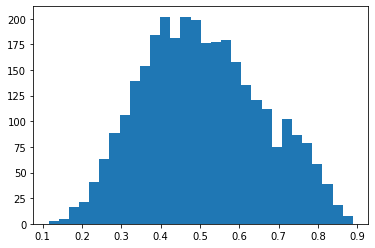

In [33]:
x = df_all['ALWAYS']
visualize_series(x, 1)

In [37]:
hypothesis_test_diff_prop(x)

(-2.4192762576320157, 0.015608133163856484, 3127.0)

In [40]:
# Similar test - should see similar results
hypothesis_test_diff_prop(df_all['NEVER'])

(2.914863965663994, 0.003583713897860535, 3127.0)

**Question: Is there a significant difference in populations where the median income is higher than average income and populations where median income is lower than average with regard to spread of Covid?**

* Populations: Higher than average income, Lower than average income
* Parameter of Interest: p1 — p2
* Null Hypothesis: p1 — p2 = 0
* Alternative Hypothesis: p1 — p2 ≠ 0

Mean: 4.990956684369296
Median: 1.9341029579348956


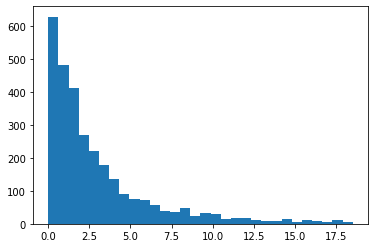

In [41]:
x = df_all['Median_Household_Income_2019']
visualize_series(x)

In [43]:
hypothesis_test_diff_prop(x)

(-0.4603722290394334, 0.6452810756476998, 3127.0)

In [48]:
# Similar test - should see similar results
hypothesis_test_diff_prop(df_all['Med_HH_Income_Percent_of_State_Total_2019'])

(1.6073481717405904, 0.10807897169918426, 3127.0)

In [66]:
hypothesis_test_diff_prop(df_all["Percent of adults with a bachelor's degree or higher, 2015-19"])

(-2.396929497647484, 0.01659146239412573, 3127.0)

In [ ]:
hypothesis_test_diff_prop(df_all["POVALL_2019"])

(2.5312247786808797, 0.011415117693500187, 3127.0)

In [73]:
hypothesis_test_diff_prop(df_all["Civilian_labor_force_2019"])

(-0.0692345622274756, 0.944807339260821, 3127.0)

#### Machine Learning Models


##### Deep Neural Network

[Slides](https://drive.google.com/file/d/1JOYfucEtRiD2wVLeTLBInp2pvDC1T9BQ/view)

[Reference](https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/)

In [75]:
# Get X and y
factors = ["Median_Household_Income_2019", 
           "Unemployment_rate_2019", "Bachelor's degree or higher, 2000", 
           "INTERNATIONAL_MIG_2019",
           "DOMESTIC_MIG_2019", "GQ_ESTIMATES_2019", "R_death_2019", 
           "POP_ESTIMATE_2019", 
           "Percent of adults with a high school diploma only, 2015-19", 
           "N_POP_CHG_2019", "POVALL_2019", "Civilian_labor_force_2019",
           "Med_HH_Income_Percent_of_State_Total_2019", 
           "hisp_pop", "black_pop", "white_pop", "Medicare enrollees (2014)",
           "2013 Urban Influence Code",
           "NEVER", "RARELY", "SOMETIMES", "FREQUENTLY", "ALWAYS"]
factors1 = ["Median_Household_Income_2019", 
           "Unemployment_rate_2019",
           "ALWAYS", "POP_ESTIMATE_2019"]
factors2 = ["Bachelor's degree or higher, 2000", "R_death_2019", 
            #"INTERNATIONAL_MIG_2019", "DOMESTIC_MIG_2019", "GQ_ESTIMATES_2019",
            "POVALL_2019", "Civilian_labor_force_2019"]
factors = factors1 + factors2
df = df_all[factors + ['cases']].dropna()
for factor in factors2 + ['cases']:
  df[factor] = df_all[factor] / df_all["POP_ESTIMATE_2019"] * 100000
df_X = df[factors]
y = df['cases'].values
# Standardize data
X = StandardScaler().fit_transform(df_X)
# y = StandardScaler().fit_transform(y.reshape(len(y),1))[:,0]
# Get training and test data
n_train = int(df_X.shape[0] / 2)
num_features = df_X.shape[1]
print(n_train, num_features)
X_train, X_test = X[:n_train, :], X[n_train:, :]
y_train, y_test = y[:n_train], y[n_train:]
X_train, X_test, y_train, y_test

1562 8


(array([[ 0.17898345, -0.89308393, -0.41969514, ..., -0.44895417,
         -0.34542302, -0.04659699],
        [ 0.29255492, -0.89308393, -0.47236567, ..., -0.52715656,
         -0.72422571, -0.41466209],
        [-1.364493  , -0.12675512, -0.11025575, ..., -0.2408893 ,
          1.88992202, -1.43700862],
        ...,
        [ 0.41784407, -0.26608763, -0.80155651, ..., -0.23145889,
         -0.91152581,  0.07662267],
        [-1.26444194, -0.19642138, -0.93323284, ...,  0.87248062,
          1.38725667,  0.14291705],
        [-1.37725072,  1.05757123, -1.31509422, ...,  0.15511504,
          1.04238537, -1.05841328]]),
 array([[-0.57739697, -0.54475266, -0.78180506, ..., -0.26850556,
          0.16451553, -0.0737253 ],
        [-0.86451507,  0.29124241, -0.60404201, ...,  0.84905314,
          1.23526992, -0.61835704],
        [-0.60880593, -0.61441891, -0.96615193, ...,  0.4646093 ,
          0.03046306,  0.15612217],
        ...,
        [ 1.04727129, -0.05708887, -1.60478215, ..., -

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/200
49/49 [==============================] - 1s 799us/step - loss: 99.9995 - mean_absolute_percentage_error: 99.9995
Epoch 2/200
49/49 [==============================] - 0s 884us/step - loss: 99.9984 - mean_absolute_percentage_error: 99.9984
Epoch 3/200
49/49 [==============================] - 0s 969us/step - loss: 99.9970 - mean_absolute_percentage_error: 99.9970
Epoch 4/200
49/49 [==============================] - 0s 998us/step - loss: 99.9956 - mean_absolute_percentage_error: 99.9956
Epoch 5/200
49/49 [==============================] - 0s 842us/step - loss: 99.9941 - mean_absolute_percentage_error: 99.9941
Epoch 6/200
49/49 [==============================] - 0s 866us/step - loss: 99.9924 - mean_absolute_percentage_error: 99.9924
Epoch 7/200
49/49 [==============================] - 0s 863us/step - loss: 99.9905 - mean_absolute_percentage_error: 99.9905
Epoch 8/200
49/49 [==============================] - 0s 989us/step - loss: 99.9883 - mean_absolute_percentage_error: 99.9883


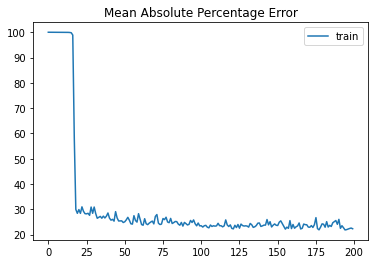

In [76]:
# define model
model = models.Sequential()
model.add(layers.Dense(10, activation='relu', input_shape=(num_features,)))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(10, activation='relu'))
# model.add(layers.Dense(10, activation='relu'))
# model.add(layers.Dense(10, activation='relu'))
# model.add(layers.Dense(10, activation='relu'))
# model.add(layers.Dense(10, activation='relu'))
# model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='linear'))
opt = tf.keras.optimizers.SGD(lr=0.01, momentum=0.9)
model.compile(loss='mean_absolute_percentage_error', optimizer=opt, metrics = ['MeanAbsolutePercentageError'])
# fit model
history = model.fit(X_train, y_train, epochs=200, verbose=1)
# evaluate the model
train_mse = model.evaluate(X_train, y_train, verbose=1)
test_mse = model.evaluate(X_test, y_test, verbose=1)
print(f'Train: {train_mse}, Test: {test_mse}')
# plot loss during training
pyplot.title('Mean Absolute Percentage Error')
pyplot.plot(history.history['mean_absolute_percentage_error'], label='train')
# pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
# Get X and y
factors = ["Median_Household_Income_2019", 
           "Unemployment_rate_2019", "Bachelor's degree or higher, 2000", 
           "INTERNATIONAL_MIG_2019",
           "DOMESTIC_MIG_2019", "GQ_ESTIMATES_2019", "R_death_2019", 
           "POP_ESTIMATE_2019", "POVALL_2019", "Civilian_labor_force_2019",
           "ALWAYS"]
df = df_all[factors + ['cases']].dropna()
df['cases'] = df_all['cases'] / df_all['POP_ESTIMATE_2019'] * 100000
df_X = df[factors]
y = df['cases'].values
# Standardize data
X = StandardScaler().fit_transform(df_X)
# y = StandardScaler().fit_transform(y.reshape(len(y),1))[:,0]
# Get training and test data
n_train = int(df_X.shape[0] / 2)
num_features = df_X.shape[1]
print(n_train, num_features)
X_train, X_test = X[:n_train, :], X[n_train:, :]
y_train, y_test = y[:n_train], y[n_train:]
X_train, X_test, y_train, y_test

1562 11


(array([[ 0.17898345, -0.89308393, -0.17158186, ..., -0.13295265,
         -0.14763306, -0.41969514],
        [ 0.29255492, -0.89308393,  0.16526388, ...,  0.24776522,
          0.27965558, -0.47236567],
        [-1.364493  , -0.12675512, -0.22854006, ..., -0.15277131,
         -0.25353046, -0.11025575],
        ...,
        [ 0.41784407, -0.26608763, -0.23685627, ..., -0.2460943 ,
         -0.23854209, -0.80155651],
        [-1.26444194, -0.19642138, -0.26227563, ..., -0.2641843 ,
         -0.28652769, -0.93323284],
        [-1.37725072,  1.05757123, -0.25521469, ..., -0.23379894,
         -0.2745358 , -1.31509422]]),
 array([[-0.57739697, -0.54475266, -0.22208715, ..., -0.21490548,
         -0.2410942 , -0.78180506],
        [-0.86451507,  0.29124241, -0.26256983, ..., -0.27343625,
         -0.29309712, -0.60404201],
        [-0.60880593, -0.61441891, -0.26211872, ..., -0.27988827,
         -0.29047895, -0.96615193],
        ...,
        [ 1.04727129, -0.05708887, -0.23552253, ..., -

In [ ]:
# Get X and y
factors = ["Median_Household_Income_2019","Bachelor's degree or higher, 2000", 
           "POVALL_2019", "Civilian_labor_force_2019", "ALWAYS"]
df = df_all.fillna(0)
df_X = df[factors]
y = df['cases'].values
# Standardize data
X = StandardScaler().fit_transform(df_X)
y = StandardScaler().fit_transform(y.reshape(len(y),1))[:,0]
# Get training and test data
n_train = int(df_X.shape[0] / 2)
num_features = df_X.shape[1]
print(n_train, num_features)
X_train, X_test = X[:n_train, :], X[n_train:, :]
y_train, y_test = y[:n_train], y[n_train:]
X_train, X_test, y_train, y_test

1564 5


(array([[ 0.17673854, -0.17127885, -0.13261123, -0.14734487, -0.41895642],
        [ 0.29011191,  0.16581684,  0.24838798,  0.28026141, -0.47162184],
        [-1.36404574, -0.22827931, -0.15244453, -0.25332099, -0.1095471 ],
        ...,
        [-0.91678155, -0.26088185, -0.27875392, -0.29085582, -0.8271134 ],
        [ 0.53568501, -0.25312868, -0.27141998, -0.27059807, -1.4327657 ],
        [-0.52855735, -0.23102727, -0.20602369, -0.24224563, -0.64278444]]),
 array([[ 0.41518254, -0.23660169, -0.24583649, -0.23832147, -0.8007807 ],
        [-1.26416919, -0.26203991, -0.26393986, -0.28634275, -0.93244424],
        [-1.37678121, -0.25497374, -0.23353204, -0.27434194, -1.31426851],
        ...,
        [ 1.04351189, -0.23526697, -0.25502218, -0.25032829, -1.60392831],
        [-0.03858781, -0.24881047, -0.27583009, -0.28094028, -1.45251523],
        [ 0.25820402, -0.2559159 , -0.27955797, -0.2817215 , -0.87977882]]),
 array([-0.07712458,  0.33105388, -0.20360028, ..., -0.26107273,
     

##### Gradient Boosting

In [78]:
factors1 = [
            "Median_Household_Income_2019",
            'Med_HH_Income_Percent_of_State_Total_2019', 
            "Unemployment_rate_2019",
            "ALWAYS", 
            "Percent of adults with a bachelor's degree or higher, 2015-19",
            "Percent of adults with a high school diploma only, 2015-19", 
            "2013 Urban Influence Code",
            "state_x",
            ]
factors2 = [
            "Bachelor's degree or higher, 2000", 
            "R_death_2019", 
            "INTERNATIONAL_MIG_2019", "DOMESTIC_MIG_2019", "GQ_ESTIMATES_2019",
            "POVALL_2019", 
            "Civilian_labor_force_2019",
            "hisp_pop", "black_pop", "white_pop", "indian_pop", "two_pop", "asian_pop",
            "Medicare enrollees (2014)",
            ]
factors = factors1 + factors2
target = 'cases'
df_copy = df_all[factors + [target]].dropna()
df_copy = pd.get_dummies(df_copy)
factors = list(df_copy.drop(columns=['cases']).columns.values)
for factor in factors2 + [target]:
  df_copy[factor] = df_all[factor] / df_all["POP_ESTIMATE_2019"] * 100000
X = df_copy[factors]
y = df_copy[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
X_train, y_train

(      Median_Household_Income_2019  ...  state_x_Wyoming
 728                        53378.0  ...                0
 2170                       56307.0  ...                0
 1204                       38731.0  ...                0
 2814                      118986.0  ...                0
 751                        53908.0  ...                0
 ...                            ...  ...              ...
 768                        51228.0  ...                0
 840                        53085.0  ...                0
 1658                       63310.0  ...                0
 2612                       72796.0  ...                0
 2737                       43788.0  ...                0
 
 [2343 rows x 71 columns], 728      9130.865420
 2170    12101.338604
 1204     9330.106184
 2814     5579.669147
 751      9087.589337
             ...     
 768     10247.174708
 840      8081.395349
 1658    10366.766467
 2612     8662.123386
 2737     4545.764794
 Name: cases, Length: 2343, dtype:

In [79]:
reg = GradientBoostingRegressor(random_state=0)
reg.fit(X_train, y_train)
reg.predict(X_test)

print("Score is (where 1 is best and a negative value the worst):", reg.score(X_test, y_test))

Score is (where 1 is best and a negative value the worst): 0.48884782944919675


[('state', 0.20779210778634447),
 ('GQ_ESTIMATES_2019', 0.1443282455957872),
 ('ALWAYS', 0.13687983953127714),
 ('hisp_pop', 0.0862802519680778),
 ('black_pop', 0.07260751555072582),
 ('two_pop', 0.0455150423997846),
 ("Bachelor's degree or higher, 2000", 0.04410025899438919),
 ('POVALL_2019', 0.03905959685531629),
 ('Civilian_labor_force_2019', 0.0357433369944402),
 ('DOMESTIC_MIG_2019', 0.035513765759293624),
 ('indian_pop', 0.03423384690950971),
 ('white_pop', 0.02443189052260406),
 ('Unemployment_rate_2019', 0.023458612282101048),
 ('Med_HH_Income_Percent_of_State_Total_2019', 0.01720747860968814),
 ("Percent of adults with a bachelor's degree or higher, 2015-19",
  0.016071261995972797),
 ('R_death_2019', 0.009214047117018932),
 ('asian_pop', 0.008537010608044255),
 ('Medicare enrollees (2014)', 0.006721821550009277),
 ('INTERNATIONAL_MIG_2019', 0.0052251050770094),
 ('Median_Household_Income_2019', 0.003761726783353317),
 ('Percent of adults with a high school diploma only, 2015-

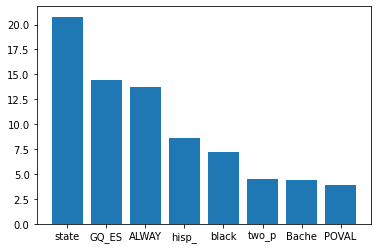

In [83]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train.columns, reg.feature_importances_):
    feats[feature] = importance
filtered_importances = {}
state_weight = 0
for col in feats:
  if col.startswith('state'):
    state_weight += feats[col]
  else:
    filtered_importances[col] = feats[col]
filtered_importances['state'] = state_weight
sorted_importances = sorted(filtered_importances.items(), key=lambda x: x[1], reverse=True)
pprint(sorted_importances)
sorted_importances = sorted_importances[:min(8, len(filtered_importances))]
keys = [i[0][:5] for i in sorted_importances]
values = [i[1] * 100 for i in sorted_importances]
plt.bar(keys, values)
plt.show()

In [88]:
threshold = 0.3
data_corr = df_copy.corr()
data_corr = data_corr.mask(np.tril(np.ones(data_corr.shape)).astype(np.bool))
data_corr = data_corr[abs(data_corr) >= threshold].stack().reset_index()
data_corr_sorted = data_corr.sort_values(0, kind="quicksort", key=lambda x: abs(x))
data_corr_sorted.columns = ["factor1", "factor2", "correlation"]
data_corr_sorted.tail(10)
# s = c.unstack()
# so = s.sort_values(kind="quicksort")
# diff_corr = pd.DataFrame(so[so.values != 1.0], columns=["corr"])
# diff_corr.reset_index()

,factor1,factor2,correlation
10,Med_HH_Income_Percent_of_State_Total_2019,Percent of adults with a bachelor's degree or ...,0.573304
56,two_pop,state_x_Hawaii,0.578980
34,Percent of adults with a high school diploma o...,"Bachelor's degree or higher, 2000",-0.625145
14,Med_HH_Income_Percent_of_State_Total_2019,POVALL_2019,-0.663126
2,Median_Household_Income_2019,Percent of adults with a bachelor's degree or ...,0.709934
27,Percent of adults with a bachelor's degree or ...,Percent of adults with a high school diploma o...,-0.776870
6,Median_Household_Income_2019,POVALL_2019,-0.784805
29,Percent of adults with a bachelor's degree or ...,"Bachelor's degree or higher, 2000",0.812107
0,Median_Household_Income_2019,Med_HH_Income_Percent_of_State_Total_2019,0.826864
49,black_pop,white_pop,-0.844232


##### Improved Deep Neural Network

[Slides](https://drive.google.com/file/d/1JOYfucEtRiD2wVLeTLBInp2pvDC1T9BQ/view)

[Reference](https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/)

In [ ]:
factors1 = [
            # "Median_Household_Income_2019",
            # 'Med_HH_Income_Percent_of_State_Total_2019', 
            # "Unemployment_rate_2019",
            "ALWAYS", 
            # "Percent of adults with a bachelor's degree or higher, 2015-19",
            # "Percent of adults with a high school diploma only, 2015-19", 
            # "2013 Urban Influence Code",
            "state_x",
            # "POP_ESTIMATE_2019"
            ]
factors2 = [
            "Bachelor's degree or higher, 2000", 
            # "R_death_2019", 
            # "INTERNATIONAL_MIG_2019", "DOMESTIC_MIG_2019", 
            "GQ_ESTIMATES_2019",
            "POVALL_2019", 
            # "Civilian_labor_force_2019",
            "hisp_pop", "black_pop", "white_pop", "indian_pop", "two_pop", "asian_pop",
            # "Medicare enrollees (2014)",
            ]
factors = factors1 + factors2
target = 'cases'
df_copy = df_all[factors + [target]].dropna()
df_copy = pd.get_dummies(df_copy)
factors = list(df_copy.drop(columns=['cases']).columns.values)
for factor in factors2 + [target]:
  df_copy[factor] = df_all[factor] / df_all["POP_ESTIMATE_2019"] * 100000
X = StandardScaler().fit_transform(df_copy[factors])
y = df_copy[target]
num_features = df_copy.shape[1] - 1
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
print(num_features)
X_train, X_test

60


(array([[-1.66403651,  0.07200076,  0.66430904, ..., -0.13386989,
         -0.15359391, -0.08612179],
        [-0.09708811,  0.16191089, -0.21071325, ..., -0.13386989,
         -0.15359391, -0.08612179],
        [ 2.00314943, -0.64326462,  3.93111245, ..., -0.13386989,
         -0.15359391, -0.08612179],
        ...,
        [-0.93981666, -0.10125026, -0.29143322, ..., -0.13386989,
         -0.15359391, -0.08612179],
        [-0.4855333 ,  0.6880634 ,  3.83534769, ..., -0.13386989,
         -0.15359391, -0.08612179],
        [ 0.7719757 , -0.93862962, -0.54630444, ..., -0.13386989,
         -0.15359391, -0.08612179]]),
 array([[ 1.1670047 ,  0.90091245, -0.45721852, ..., -0.13386989,
         -0.15359391, -0.08612179],
        [ 0.8114786 , -0.58225126, -0.70683956, ..., -0.13386989,
         -0.15359391, -0.08612179],
        [ 0.02142059, -0.62224254, -0.46299047, ..., -0.13386989,
         -0.15359391, -0.08612179],
        ...,
        [ 0.33744379,  0.14911211, -0.041813  , ..., -

In [ ]:
# define model
model = models.Sequential()
model.add(layers.Dense(num_features - 1, activation='relu', input_shape=(num_features,)))
model.add(layers.Dense(num_features - 1, activation='relu'))
model.add(layers.Dense(num_features - 1, activation='relu'))
model.add(layers.Dense(num_features - 1, activation='relu'))
model.add(layers.Dense(1, activation='linear'))
opt = tf.keras.optimizers.SGD(lr=0.01, momentum=0.9)
model.compile(loss='mean_absolute_percentage_error', optimizer=opt, metrics = ['MeanAbsolutePercentageError'])
# fit model
history = model.fit(X_train, y_train, epochs=80, verbose=1, validation_data=(X_test, y_test))
# evaluate the model
train_mse = model.evaluate(X_train, y_train, verbose=1)
test_mse = model.evaluate(X_test, y_test, verbose=1)
print(f'Train: {train_mse}, Test: {test_mse}')

Epoch 1/80
74/74 [==============================] - 1s 8ms/step - loss: 100.0014 - mean_absolute_percentage_error: 100.0014 - val_loss: 99.9930 - val_mean_absolute_percentage_error: 99.9930
Epoch 2/80
74/74 [==============================] - 0s 2ms/step - loss: 99.9865 - mean_absolute_percentage_error: 99.9865 - val_loss: 99.9681 - val_mean_absolute_percentage_error: 99.9681
Epoch 3/80
74/74 [==============================] - 0s 2ms/step - loss: 99.9495 - mean_absolute_percentage_error: 99.9495 - val_loss: 99.8609 - val_mean_absolute_percentage_error: 99.8609
Epoch 4/80
74/74 [==============================] - 0s 2ms/step - loss: 99.4774 - mean_absolute_percentage_error: 99.4774 - val_loss: 78.3683 - val_mean_absolute_percentage_error: 78.3683
Epoch 5/80
74/74 [==============================] - 0s 2ms/step - loss: 53.2869 - mean_absolute_percentage_error: 53.2869 - val_loss: 23.1467 - val_mean_absolute_percentage_error: 23.1467
Epoch 6/80
74/74 [==============================] - 0s 2ms

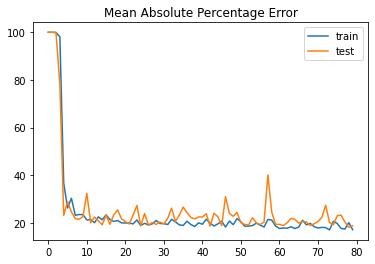

In [ ]:
# plot loss during training
pyplot.title('Mean Absolute Percentage Error')
pyplot.plot(history.history['mean_absolute_percentage_error'], label='train')
# val_mean_absolute_percentage_error
pyplot.plot(history.history['val_mean_absolute_percentage_error'], label='test')
pyplot.legend()
pyplot.show()

### Predictive models 
(Not relevant - for future work reference)

In [ ]:
df_covid_by_sex_and_age = pd.read_csv(data_dir + "Provisional_COVID-19_Death_Counts_by_Sex__Age__and_Week.csv")
df_covid_by_sex_and_age["End Week"] = pd.to_datetime(df_covid_by_sex_and_age["End Week"])
df_covid_by_sex_and_age.head(10)

,Data as of,State,MMWR Week,End Week,Sex,Age Group,Total Deaths,COVID-19 Deaths
0,01/13/2021,United States,1,2020-01-04,All Sex,All Ages,35007,2
1,01/13/2021,United States,1,2020-01-04,All Sex,Under 1 year,216,0
2,01/13/2021,United States,1,2020-01-04,All Sex,1-4 years,40,0
3,01/13/2021,United States,1,2020-01-04,All Sex,5-14 years,59,0
4,01/13/2021,United States,1,2020-01-04,All Sex,15-24 years,370,0
5,01/13/2021,United States,1,2020-01-04,All Sex,25-34 years,718,0
6,01/13/2021,United States,1,2020-01-04,All Sex,35-44 years,1057,0
7,01/13/2021,United States,1,2020-01-04,All Sex,45-54 years,1850,0
8,01/13/2021,United States,1,2020-01-04,All Sex,55-64 years,4615,0
9,01/13/2021,United States,1,2020-01-04,All Sex,65-74 years,6895,1


In [ ]:
# Get covid related stats grouped by death
df_covid_by_sex_and_age.groupby('Sex').mean()

,MMWR Week,Total Deaths,COVID-19 Deaths
Sex,,,
All Sex,26.518519,10022.194444,1017.240741
Female,26.518519,4788.567901,465.734568
Male,26.518519,5233.626543,551.506173


      Data as of          State  ...  COVID-19 Deaths Total Covid Deaths
1773  01/13/2021  United States  ...             3224              65714
1809  01/13/2021  United States  ...             2368              68082
1845  01/13/2021  United States  ...              961              69043
1881  01/13/2021  United States  ...              812              69855
1917  01/13/2021  United States  ...              374              70229

[5 rows x 9 columns]


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/deterministic.py:152: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  UserWarning,


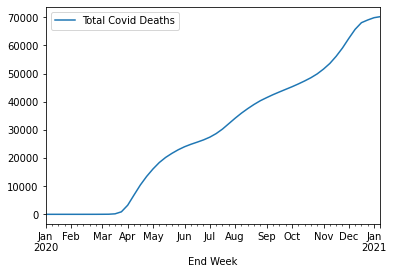

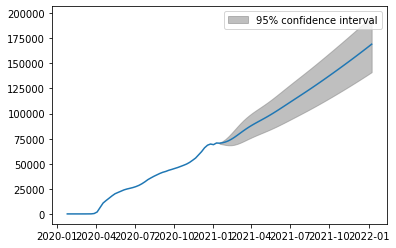

In [ ]:
df_all = get_data_by_age_sex("65-74 years", "All Sex")
print(df_all.tail())
plotTrueData(df_all)
plotPrediction(df_all)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/deterministic.py:152: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  UserWarning,


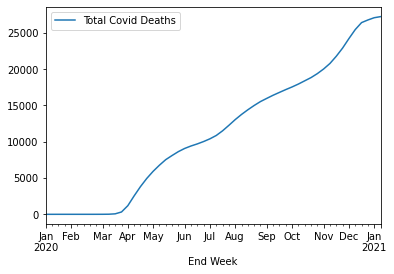

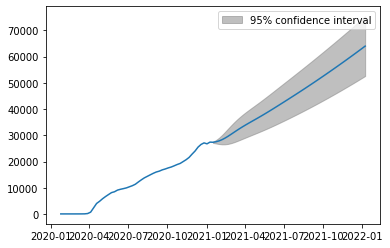

In [ ]:
df_fem = get_data_by_age_sex("65-74 years", "Female")
plotTrueData(df_fem)
plotPrediction(df_fem)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/deterministic.py:152: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  UserWarning,


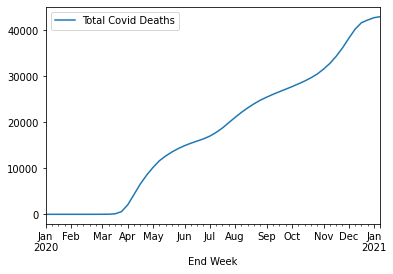

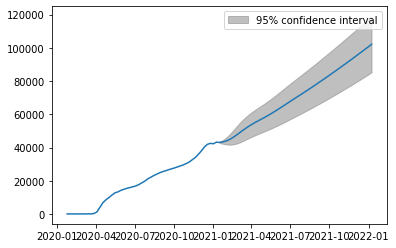

In [ ]:
df_male = get_data_by_age_sex("65-74 years", "Male")
plotTrueData(df_male)
plotPrediction(df_male)

      Data as of          State  ...  COVID-19 Deaths Total Covid Deaths
1769  01/13/2021  United States  ...               53               2121
1805  01/13/2021  United States  ...               48               2169
1841  01/13/2021  United States  ...               13               2182
1877  01/13/2021  United States  ...               10               2192
1913  01/13/2021  United States  ...                4               2196

[5 rows x 9 columns]


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/deterministic.py:152: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  UserWarning,


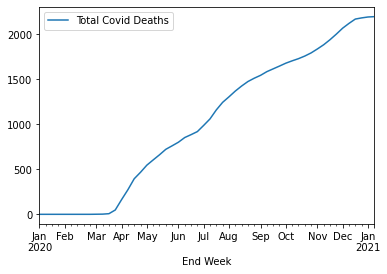

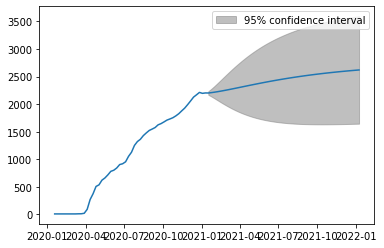

In [ ]:
df_all = get_data_by_age_sex("25-34 years", "All Sex")
print(df_all.tail())
plotTrueData(df_all)
plotPrediction(df_all)

      Data as of          State  ...  COVID-19 Deaths Total Covid Deaths
1793  01/13/2021  United States  ...               20                768
1829  01/13/2021  United States  ...               15                783
1865  01/13/2021  United States  ...                6                789
1901  01/13/2021  United States  ...                6                795
1937  01/13/2021  United States  ...                0                795

[5 rows x 9 columns]


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/deterministic.py:152: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  UserWarning,


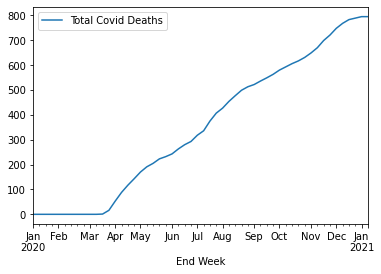

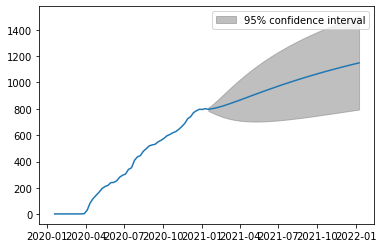

In [ ]:
df_all = get_data_by_age_sex("25-34 years", "Female")
print(df_all.tail())
plotTrueData(df_all)
plotPrediction(df_all)

      Data as of          State  ...  COVID-19 Deaths Total Covid Deaths
1781  01/13/2021  United States  ...               33               1353
1817  01/13/2021  United States  ...               33               1386
1853  01/13/2021  United States  ...                7               1393
1889  01/13/2021  United States  ...                4               1397
1925  01/13/2021  United States  ...                4               1401

[5 rows x 9 columns]


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/deterministic.py:152: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  UserWarning,


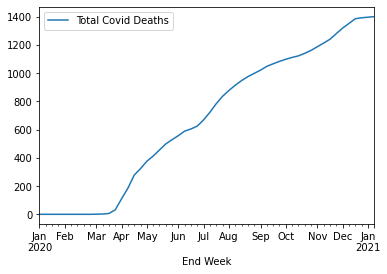

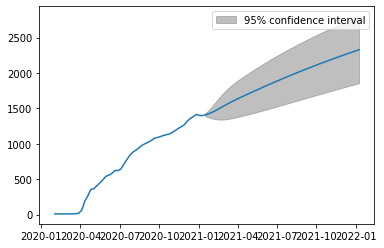

In [ ]:
df_all = get_data_by_age_sex("25-34 years", "Male")
print(df_all.tail())
plotTrueData(df_all)
plotPrediction(df_all)